In [1]:
import numpy as np
import os
import plotly
import plotly.graph_objects as go
import plotly.express as px
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import sqlite3
import networkx as nx
import multinetx as mx
from tqdm import tqdm
from scipy import sparse
plotly.offline.init_notebook_mode(connected=True)
import random
import pickle 


In [2]:
plotly.offline.init_notebook_mode(connected=True)


In [3]:
os.getcwd()
os.chdir('C:\\Users\\rduvo\\Desktop\\ComplexNetwork\\Idea_of_Project\\circuitdata\\mouseretina')

## Download Graph

In [4]:
def Transform_binary_mat(adj_weighted):
    sz_clm=len(adj_weighted[0])
    if sz_clm==1:
        sz_clm=len(np.array(adj_weighted[0])[0])
    sz_row=len(adj_weighted)
    adj_NW=np.zeros_like(adj_weighted)
    for i in range(sz_row):
        for j in range(sz_clm):
            if adj_weighted[i,j]>0:
                adj_NW[i,j]=1
    return adj_NW

In [5]:
G=nx.read_gml("Monolayer_Matrix_weighted.gml")

In [6]:
gc_layer=[1,36]
nac_layer=[37,217]
mwaclayer=[218,389]
other_layer=[390,413]
bc_layer=[414,840]
None_layer=[841,950]
bc_newlay=[lay-(other_layer[1]-other_layer[0]+1) for lay in bc_layer]

All_limit=[lay[1] for lay in [gc_layer,nac_layer,mwaclayer,other_layer,bc_layer,None_layer]]
All_lim_lab=['gc_e','nac_e','mwac_e','other_e','bc_e','None_e']

All_limit_of_interest_name=['gc','nac','mwac','bc']
All_limit_of_interest=[lay for lay in [gc_layer,nac_layer,mwaclayer,bc_newlay]]


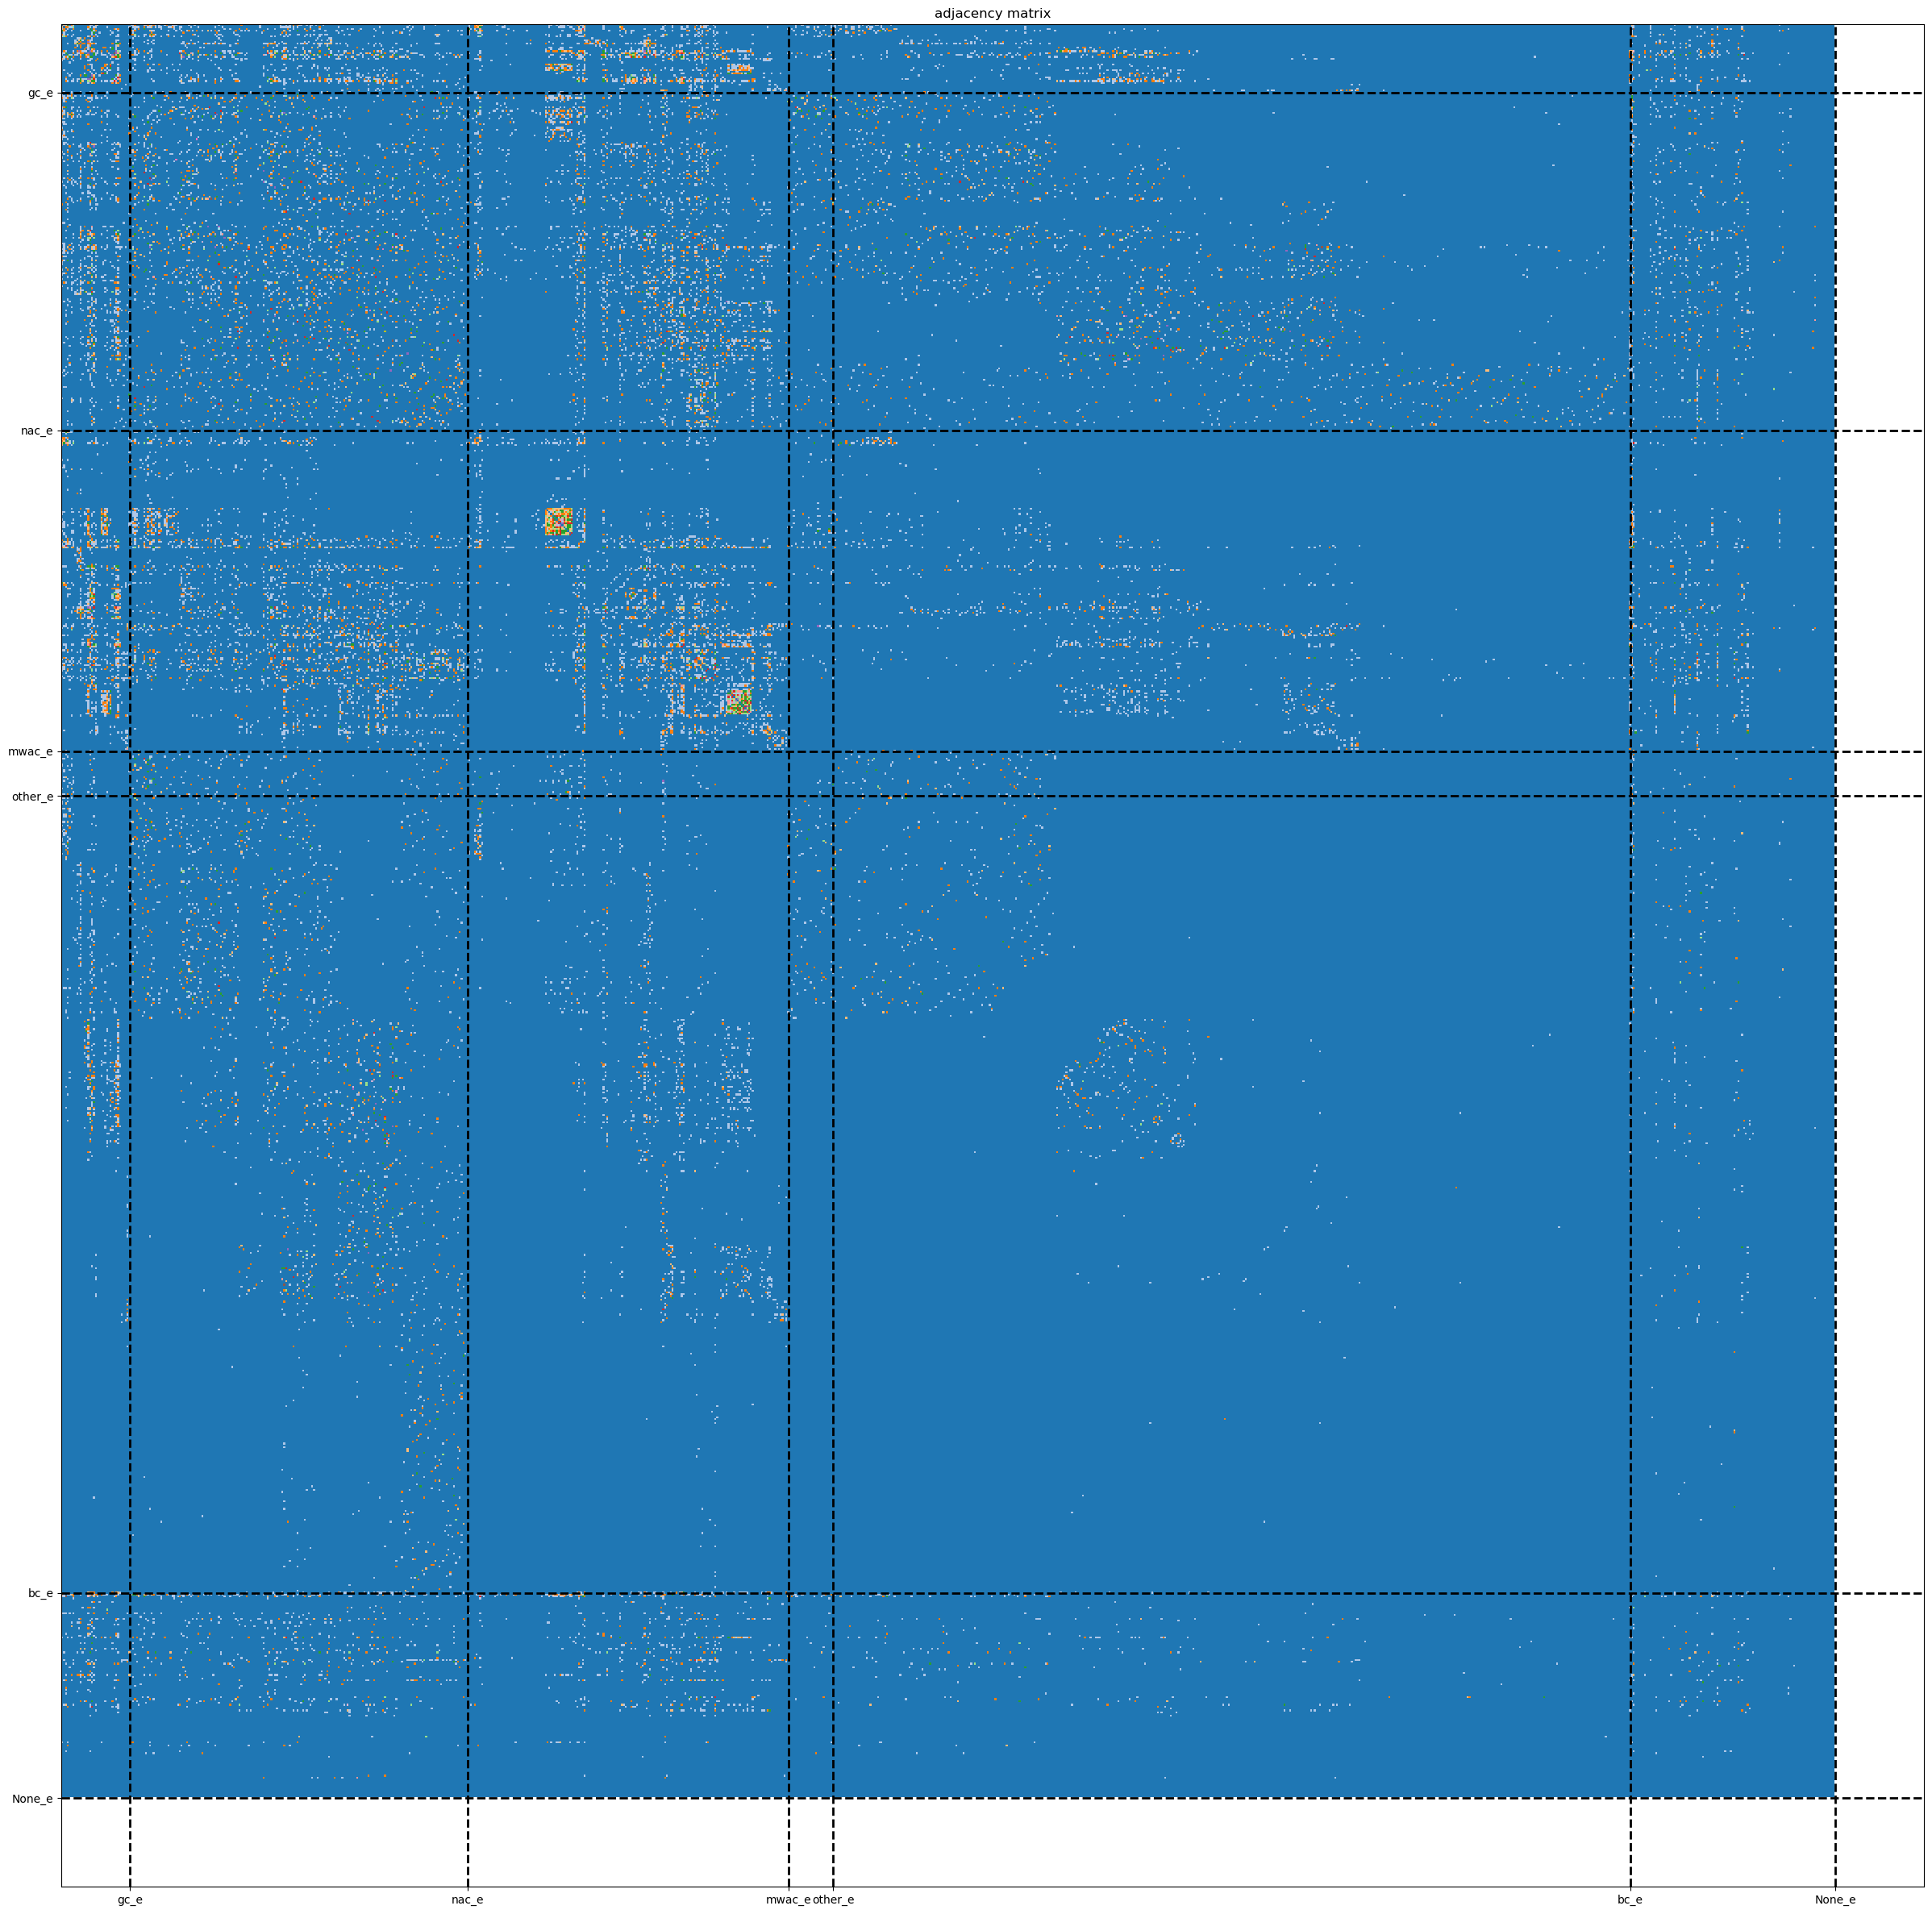

In [7]:
Adj_mat_monolayer=nx.adjacency_matrix(G,weight='weight')
fig_adjmat_monolayer = plt.figure(figsize=(30,30))
plt.imshow(Adj_mat_monolayer.todense(), origin='upper',interpolation='nearest',cmap=plt.cm.tab20)
for lay in [gc_layer,nac_layer,mwaclayer,other_layer,bc_layer,None_layer]:
    plt.axvline(x=lay[1],ymin=0, ymax=900,color='black', linewidth=2,linestyle='--')
    plt.axhline(y=lay[1],xmin=0, xmax=900,color='black', linewidth=2,linestyle='--')

plt.xticks(ticks=All_limit, labels=All_lim_lab)
plt.yticks(ticks=All_limit, labels=All_lim_lab)

plt.title('adjacency matrix')
plt.show()

In [8]:
# Generate Super-adj-mat without other or None

sz_f=sum([np.diff(lay)+1 for lay in All_limit_of_interest]) #+1 because need to count the 1st node of each cat
Final_super_adj_mat_w=np.zeros((sz_f[0],sz_f[0]))
Dense_mat=Adj_mat_monolayer.todense()


#-1 for indexing because mat start at 0 but node name start at 1
bc_newlay_bis=[l-1 for l in bc_newlay]
for i,lay_i in enumerate(All_limit_of_interest):
    for j,lay_j in enumerate(All_limit_of_interest):
        Name_row=All_limit_of_interest_name[i]
        Name_colum=All_limit_of_interest_name[j]
        #-1 for indexing because mat start at 0 but node name start at 1
        lay_i_bis=[l-1 for l in lay_i]
        lay_j_bis=[l-1 for l in lay_j]
        bc_newlay_bis=[l-1 for l in bc_newlay]
        if Name_row=='bc' and Name_colum!='bc':
            #-1 for indexing because mat start at 0 but node name start at 1
            Final_super_adj_mat_w[bc_newlay_bis[0]:bc_newlay_bis[1],lay_j_bis[0]:lay_j_bis[1]]=Dense_mat[lay_i_bis[0]:lay_i_bis[1],lay_j_bis[0]:lay_j_bis[1]]
        elif Name_colum=='bc' and Name_row!='bc':
            Final_super_adj_mat_w[lay_i_bis[0]:lay_i_bis[1],bc_newlay_bis[0]:bc_newlay_bis[1]]=Dense_mat[lay_i_bis[0]:lay_i_bis[1],lay_j_bis[0]:lay_j_bis[1]]
        elif Name_colum=='bc' and Name_row=='bc':
            Final_super_adj_mat_w[bc_newlay_bis[0]:bc_newlay_bis[1],bc_newlay_bis[0]:bc_newlay_bis[1]]=Dense_mat[lay_i_bis[0]:lay_i_bis[1],lay_j_bis[0]:lay_j_bis[1]]
        else:
            Final_super_adj_mat_w[lay_i_bis[0]:lay_i_bis[1],lay_j_bis[0]:lay_j_bis[1]]=Dense_mat[lay_i_bis[0]:lay_i_bis[1],lay_j_bis[0]:lay_j_bis[1]]
Final_super_adj_mat_Binary=Transform_binary_mat(Final_super_adj_mat_w)

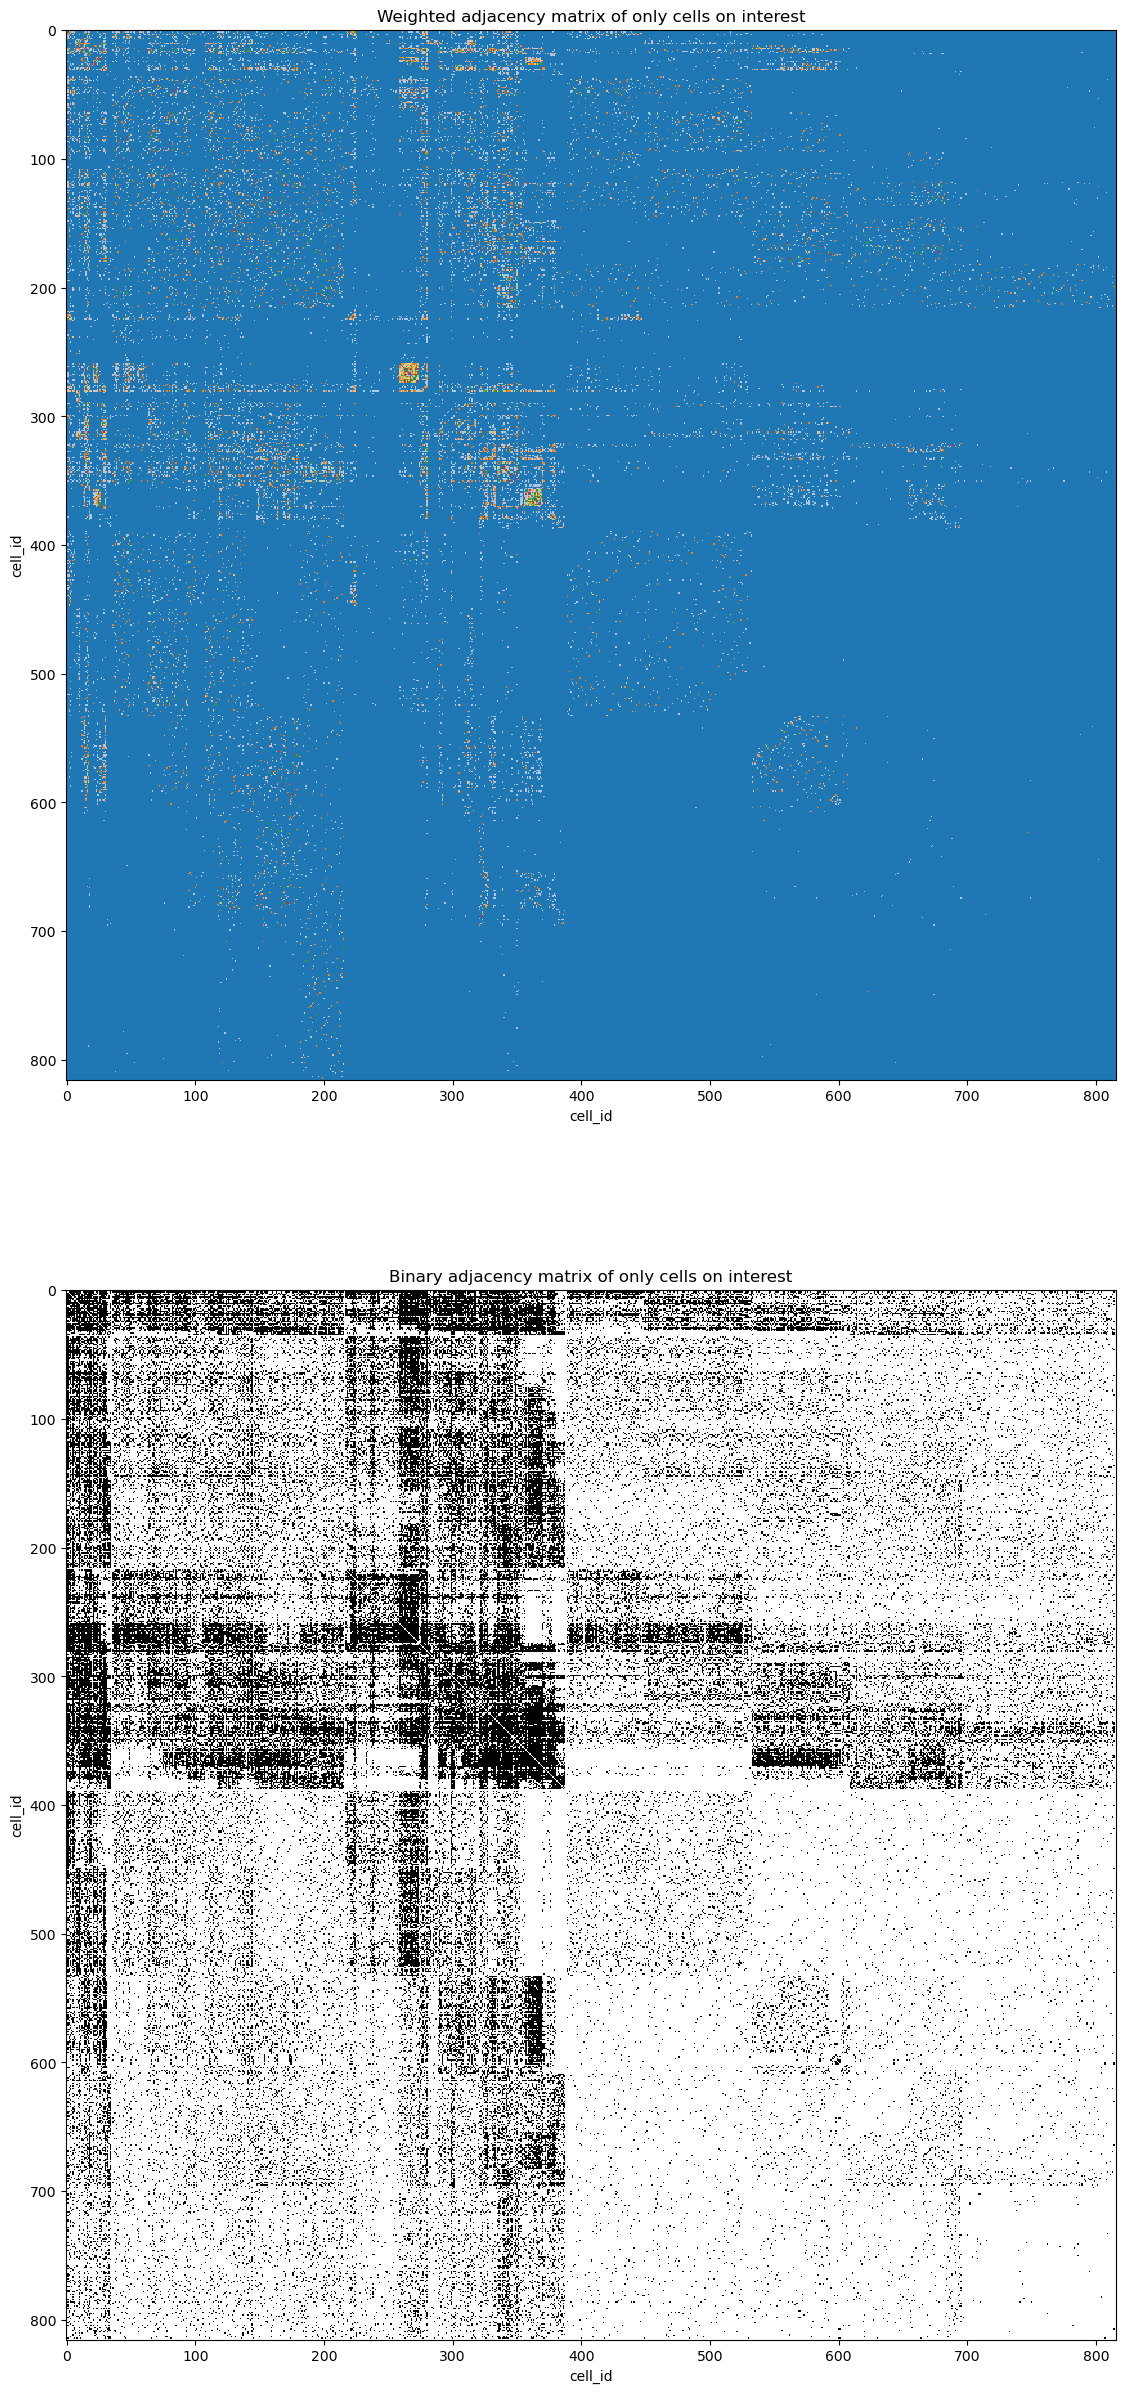

In [9]:
fig_adjmat_OI_monolayer,axs = plt.subplots(2,1,figsize=(30,30))
axs[0].imshow(Final_super_adj_mat_w, origin='upper',interpolation='nearest',cmap=plt.cm.tab20)
axs[0].set(xlabel='cell_id',ylabel='cell_id')
for lay in [gc_layer,nac_layer,mwaclayer,bc_newlay]:
    jrubrjrkk=1

axs[0].set_title('Weighted adjacency matrix of only cells on interest')

axs[1].imshow(Final_super_adj_mat_Binary, origin='upper',interpolation='nearest',cmap=plt.cm.binary)
for lay in [gc_layer,nac_layer,mwaclayer,bc_newlay]:
    rhhrioe=1
    #axs[1].axvline(x=lay[1],ymin=0, ymax=800,color='red', linewidth=2,linestyle='--')
    #axs[1].axhline(y=lay[1],xmin=0, xmax=800,color='red', linewidth=2,linestyle='--')
axs[1].set(xlabel='cell_id',ylabel='cell_id')

axs[1].set_title('Binary adjacency matrix of only cells on interest')
plt.show()

In [10]:
# Generate dict of each Adj_mat (upperdiag)

All_adj_sub_M={}

Dense_mat=Final_super_adj_mat_w

for i,lay_i in enumerate(All_limit_of_interest):
    for j,lay_j in enumerate(All_limit_of_interest):
        if lay_i<=lay_j:
            Name_row=All_limit_of_interest_name[i]
            Name_colum=All_limit_of_interest_name[j]
            Name=Name_row+'_'+Name_colum
            
            #-1 for indexing because mat start at 0 but node name start at 1
            Mat_oi=Dense_mat[lay_i[0]-1:lay_i[1]-1,lay_j[0]-1:lay_j[1]-1]
            spare_mat = sparse.csr_matrix(Mat_oi)
            All_adj_sub_M[Name+'_matrice']=spare_mat
            if lay_i==lay_j:
                All_adj_sub_M[Name+'_graph']=nx.from_numpy_array(Mat_oi)
                nx.write_gml(nx.from_numpy_array(Mat_oi),Name_row+'_'+Name_row+'_W.gml')

4it [00:00, 14.49it/s]


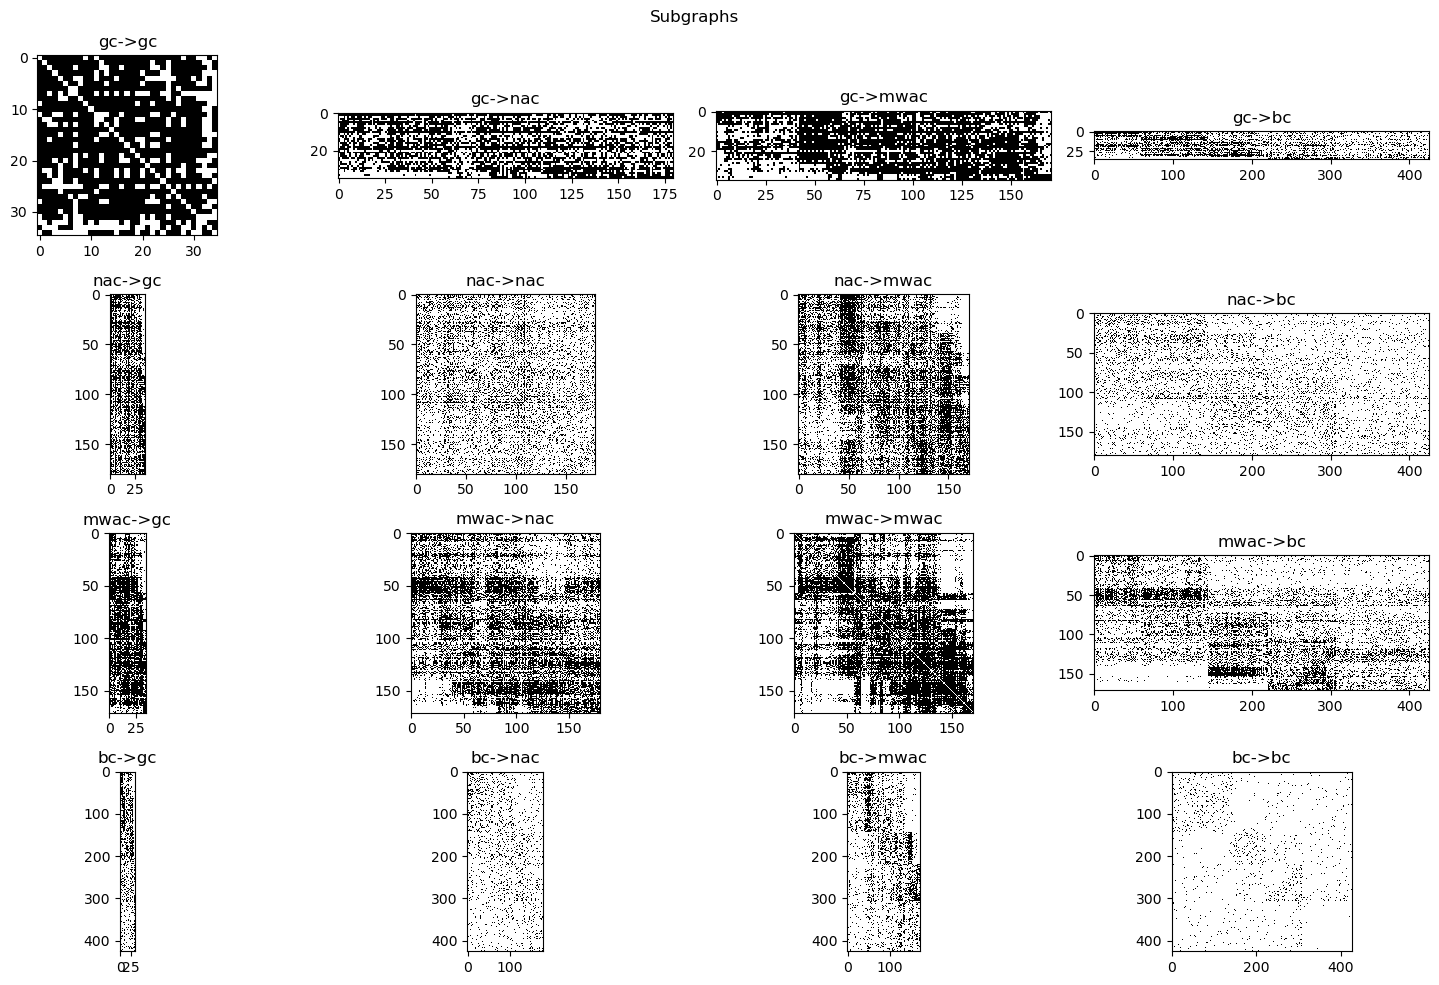

In [11]:
fig_all_matrice,axs = plt.subplots(4,4,figsize=(15,10))
for i,lay_i in tqdm(enumerate(All_limit_of_interest)):
    for j,lay_j in enumerate(All_limit_of_interest):

        if lay_i<=lay_j:
            name_lay_i=All_limit_of_interest_name[i]
            name_lay_j=All_limit_of_interest_name[j]
            adj_weig_subg=np.squeeze(np.array(All_adj_sub_M[name_lay_i+'_'+name_lay_j+'_matrice'].todense()))
            adj_NW_subg=Transform_binary_mat(adj_weig_subg)
        if lay_i>lay_j:
            name_lay_i=All_limit_of_interest_name[i]
            name_lay_j=All_limit_of_interest_name[j]
            adj_weig_subg=np.squeeze(np.array(All_adj_sub_M[name_lay_j+'_'+name_lay_i+'_matrice'].todense())).T
            adj_NW_subg=Transform_binary_mat(adj_weig_subg)

        axs[i][j].imshow(adj_NW_subg, origin='upper',interpolation='nearest',cmap=plt.cm.binary)

        axs[i][j].set_title(name_lay_i+'->'+name_lay_j)

        
fig_all_matrice.suptitle('Subgraphs') 
fig_all_matrice.tight_layout() 

In [12]:
dict_data_f={'N1':[],'N2':[],'N_tot':[],'Edges':[],'Synapses':[],'Edges/Nodes':[],'Synapses/Nodes':[],'Synapses/Edges':[]}
Dict_N_tot={'gc':[],'nac':[],'mwac':[],'bc':[]}
Dict_E_tot={'gc':[],'nac':[],'mwac':[],'bc':[]}

Dict_E_N={'gc':[],'nac':[],'mwac':[],'bc':[]}
Dict_W_N={'gc':[],'nac':[],'mwac':[],'bc':[]}
Dict_S_E={'gc':[],'nac':[],'mwac':[],'bc':[]}
index_df=[]
index_df_SOLO=All_limit_of_interest_name
for i,lay_i in enumerate(All_limit_of_interest):
    for j,lay_j in enumerate(All_limit_of_interest):

        if lay_i<=lay_j:
            name_lay_i=All_limit_of_interest_name[i]
            name_lay_j=All_limit_of_interest_name[j]
            adj_weig_subg=np.squeeze(np.array(All_adj_sub_M[name_lay_i+'_'+name_lay_j+'_matrice'].todense()))
            adj_NW_subg=Transform_binary_mat(adj_weig_subg) 
            N1=adj_NW_subg.shape[0]
            N2=adj_NW_subg.shape[1]
            E_n=np.sum(adj_NW_subg.flatten())
            W_n=np.sum(adj_weig_subg.flatten())
            if lay_i==lay_j:
                E_n=E_n/2
                N_tot=N1
                W_n=W_n/2
            else:
                N_tot=N1+N2
            #print(name_lay_i+'->'+name_lay_j)
            #print('N1 = ',N1,'/ N2 = ',N2)
            #print('Numbers of Edges ',E_n)
            #print('Numbers of Weights ',W_n)
            dict_data_f['N1'].append(N1)
            dict_data_f['N2'].append(N2)
            dict_data_f['N_tot'].append(N_tot)
            dict_data_f['Edges'].append(E_n)
            dict_data_f['Synapses'].append(W_n)
            dict_data_f['Edges/Nodes'].append(E_n/N_tot)
            dict_data_f['Synapses/Nodes'].append(W_n/N_tot)
            dict_data_f['Synapses/Edges'].append(W_n/E_n)
            index_df.append(name_lay_i+'->'+name_lay_j)
            
            Dict_N_tot[name_lay_i].append(N_tot)
            Dict_E_tot[name_lay_i].append(E_n)
            Dict_E_N[name_lay_i].append(E_n/N_tot)
            Dict_W_N[name_lay_i].append(W_n/N_tot)
            Dict_S_E[name_lay_i].append(W_n/E_n)
        if lay_i>lay_j:
            name_lay_i=All_limit_of_interest_name[i]
            name_lay_j=All_limit_of_interest_name[j]
            adj_weig_subg=np.squeeze(np.array(All_adj_sub_M[name_lay_j+'_'+name_lay_i+'_matrice'].todense())).T
            adj_NW_subg=Transform_binary_mat(adj_weig_subg)
            N1=adj_NW_subg.shape[0]
            N2=adj_NW_subg.shape[1]
            E_n=np.sum(adj_NW_subg.flatten())
            W_n=np.sum(adj_weig_subg.flatten())
            if lay_i==lay_j:
                E_n=E_n/2
                N_tot=N1
                W_n=W_n/2
            else:
                N_tot=N1+N2
            Dict_N_tot[name_lay_i].append(N_tot)
            Dict_E_N[name_lay_i].append(E_n/N_tot)
            Dict_W_N[name_lay_i].append(W_n/N_tot)
            Dict_S_E[name_lay_i].append(W_n/E_n)
            Dict_E_tot[name_lay_i].append(E_n)

        #axs[i][j].imshow(adj_NW_subg, origin='upper',interpolation='nearest',cmap=plt.cm.binary)
        #Dict_N_tot[name_lay_i].append(N_tot)
        
        #print('-----')
df_Table_Multilayer=pd.DataFrame(dict_data_f,index=index_df)
df_Table_Multilayer

N1   N2  N_tot    Edges  Synapses  Edges/Nodes  Synapses/Nodes  \
gc->gc       35   35     35    444.0    5874.0    12.685714      167.828571   
gc->nac      35  180    215   3492.0   28843.0    16.241860      134.153488   
gc->mwac     35  171    206   3839.0   33716.0    18.635922      163.669903   
gc->bc       35  426    461   4545.0   22884.0     9.859002       49.639913   
nac->nac    180  180    180   3416.0   44651.0    18.977778      248.061111   
nac->mwac   180  171    351  13433.0   95327.0    38.270655      271.586895   
nac->bc     180  426    606   8091.0   71014.0    13.351485      117.184818   
mwac->mwac  171  171    171   7482.0   56520.0    43.754386      330.526316   
mwac->bc    171  426    597  15266.0   63346.0    25.571189      106.107203   
bc->bc      426  426    426   3020.0   15575.0     7.089202       36.561033   

            Synapses/Edges  
gc->gc           13.229730  
gc->nac           8.259737  
gc->mwac          8.782495  
gc->bc            5.034983  
nac->nac         13.071136  
nac->mwac         7.096479  
nac->bc           8.776913  
mwac->mwac        7.554130  
mwac->bc          4.149483  
bc->bc            5.157285

In [13]:
df_Table_E_N=pd.DataFrame(Dict_E_N,index=index_df_SOLO)
df_Table_W_N=pd.DataFrame(Dict_W_N,index=index_df_SOLO)
df_Table_N_tot=pd.DataFrame(Dict_N_tot,index=index_df_SOLO)
df_Table_S_E=pd.DataFrame(Dict_S_E,index=index_df_SOLO)
df_Table_E_tot=pd.DataFrame(Dict_E_tot,index=index_df_SOLO)


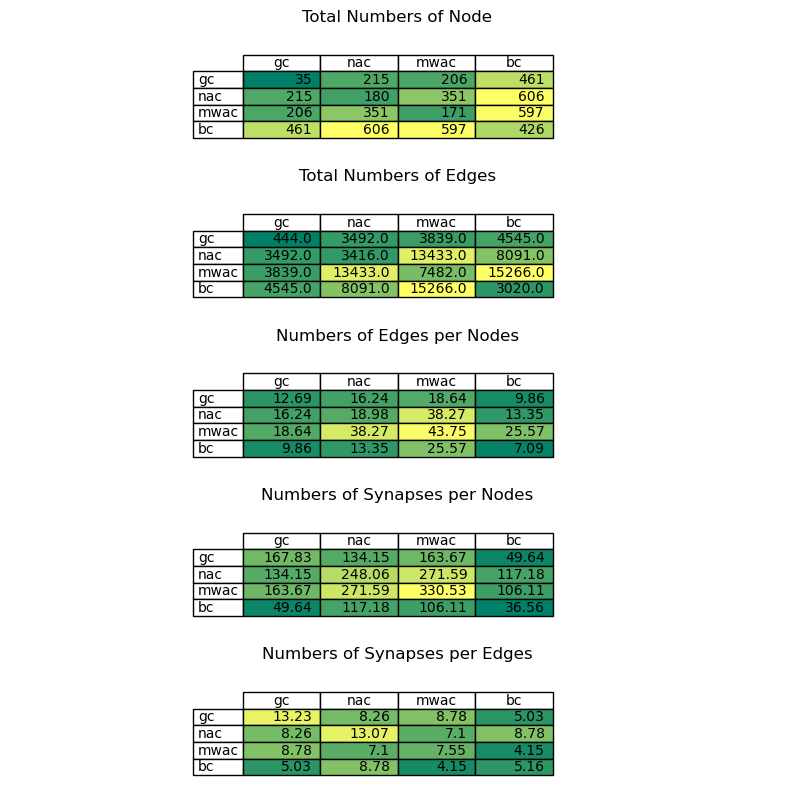

In [16]:
DF_all=[df_Table_N_tot,df_Table_E_tot,df_Table_E_N,df_Table_W_N,df_Table_S_E]
Tit=['Total Numbers of Node','Total Numbers of Edges','Numbers of Edges per Nodes','Numbers of Synapses per Nodes',
     'Numbers of Synapses per Edges']
fig_each_lay_specificity,axs=plt.subplots(5,1,figsize=(10,10))
for i,df_i in enumerate(DF_all):
    val = np.around(df_i.values,2)
    normaliz = plt.Normalize(val.min()-1, val.max()+1)
    colour_t = plt.cm.summer(normaliz(val))
    the_table=axs[i].table(cellText=val, rowLabels=df_i.index, colLabels=df_i.columns, 
                     colWidths = [0.1]*val.shape[1],loc='center', 
                    cellColours=colour_t)
    axs[i].set_axis_off()
    axs[i].set(title=Tit[i])

#ax = fig.add_subplot(111, xticks=[], yticks=[])


In [17]:
# Generate Weighted graph with this new adj matrix
Final_wG=nx.from_numpy_array(Final_super_adj_mat_w,edge_attr='weight')
nx.write_gml(Final_wG,'Final_graph_cleaned.gml')

In [18]:
Colors_l=['blue','green','orange','red']

## Weight distribution

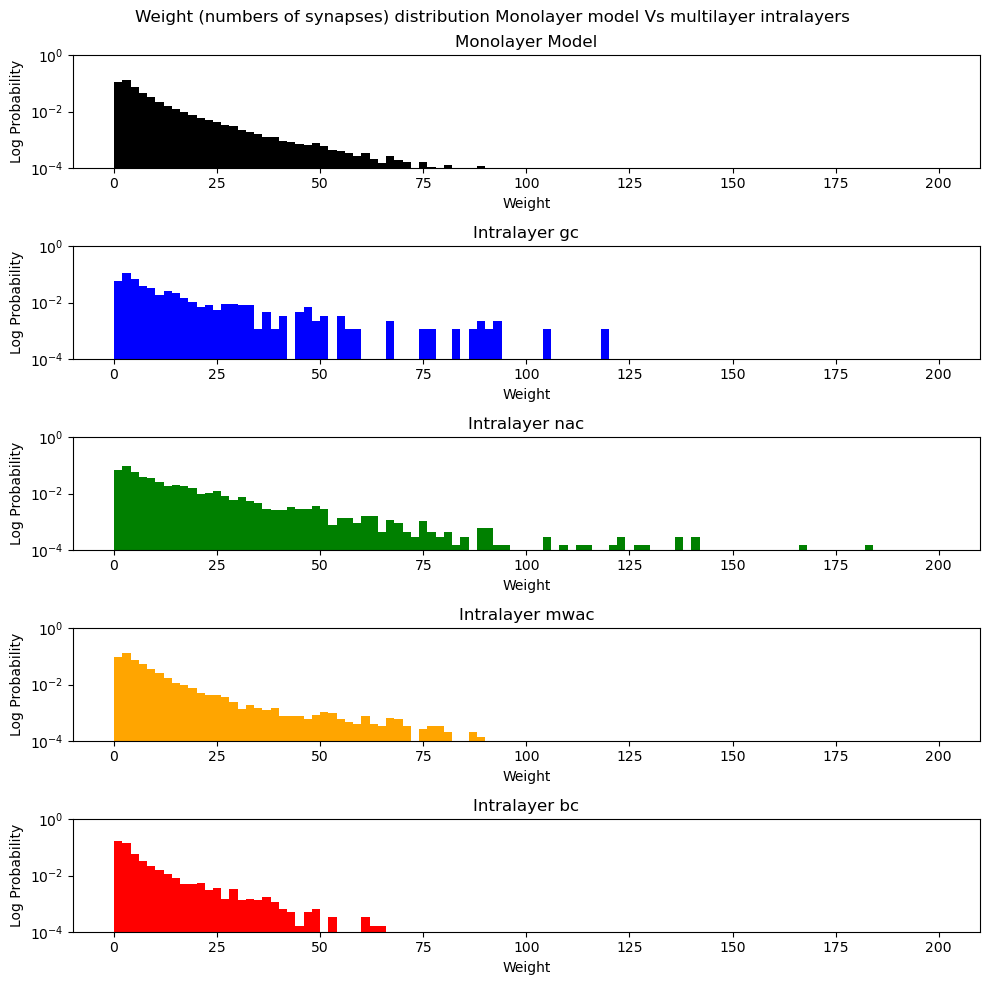

In [19]:
fig_all_weights_distrib,axs = plt.subplots(5,1,figsize=(10,10))

# Monolayer
W=Final_wG.edges.data('weight')
All_weight=[w_i[2] for w_i in W]
dat,bns,patches=axs[0].hist(All_weight,bins=100,range=[0,200],color='black',log=True,density=True)
axs[0].set_title('Monolayer Model')
axs[0].set(xlabel='Weight',ylabel='Log Probability')
axs[0].set_ylim(ymin=10e-5,ymax=10e-1)

# Multilayer
for i,lay_i in enumerate(All_limit_of_interest):
    name_lay_i=All_limit_of_interest_name[i]
    All_weight_subg=[w_i[2] for w_i in All_adj_sub_M[name_lay_i+'_'+name_lay_i+'_graph'].edges.data('weight')]
    dat,bns,patches=axs[i+1].hist(All_weight_subg,bins=100,range=[0,200],log=True,color=Colors_l[i],density=True)
    axs[i+1].set_title('Intralayer '+name_lay_i)
    axs[i+1].set(xlabel='Weight',ylabel='Log Probability')
    axs[i+1].set_ylim(ymin=10e-5,ymax=10e-1)
    
fig_all_weights_distrib.suptitle('Weight (numbers of synapses) distribution Monolayer model Vs multilayer intralayers ') 
fig_all_weights_distrib.tight_layout() 


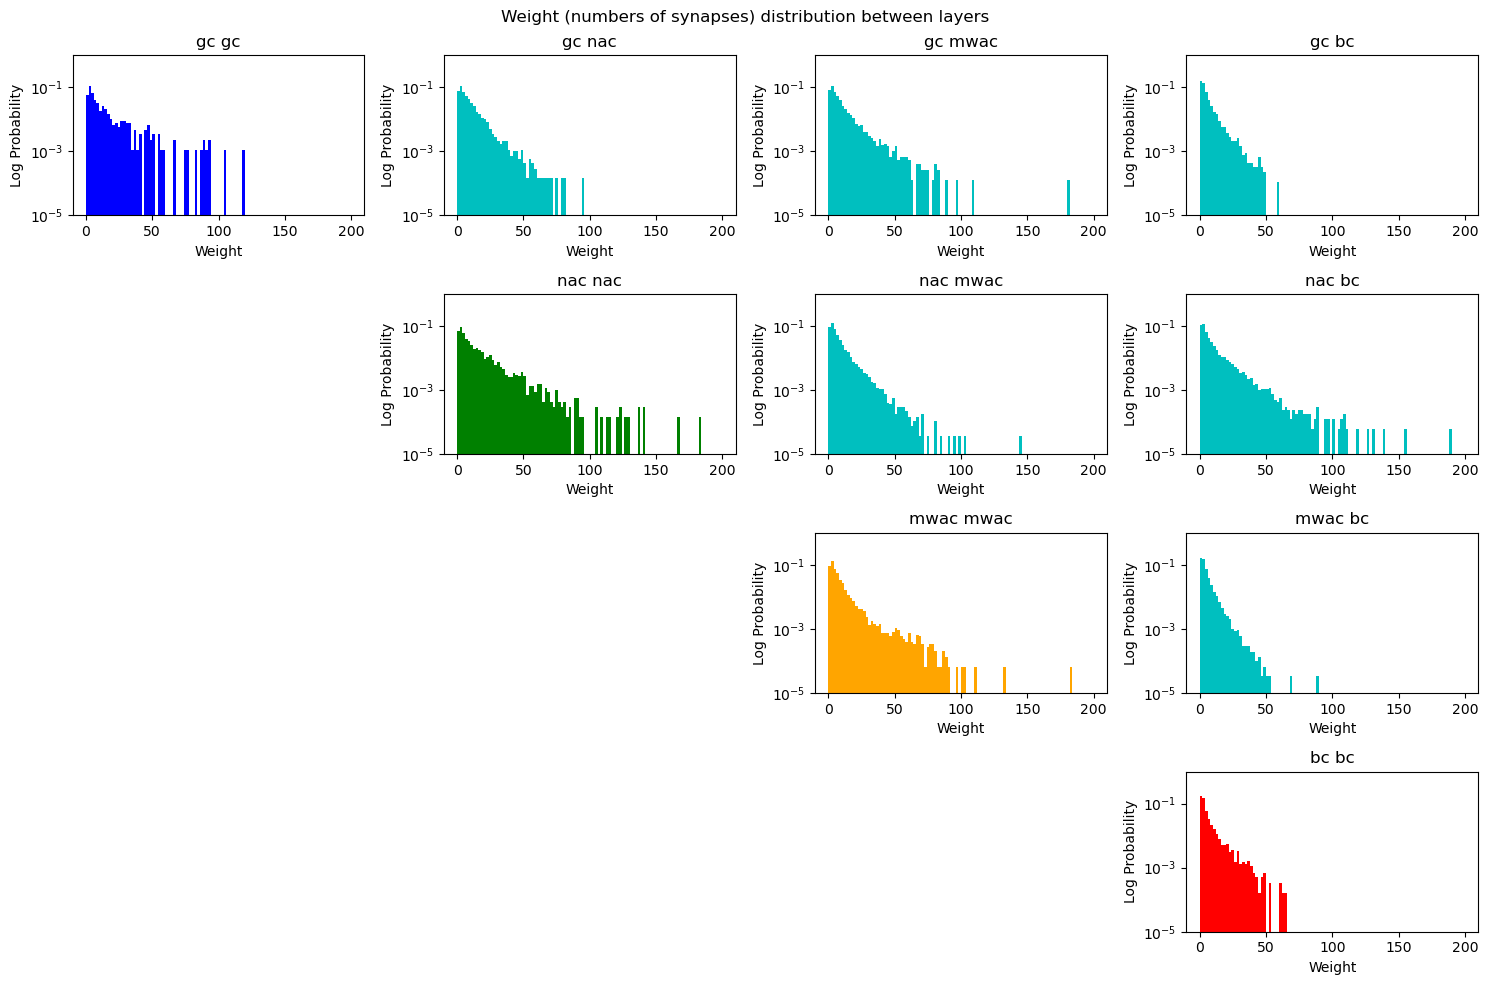

In [20]:
fig_all_weights_distrib_inter_intra,axs = plt.subplots(4,4,figsize=(15,10))
#AxesF=axs.flat
for i,lay_i in enumerate(All_limit_of_interest):
    for j,lay_j in enumerate(All_limit_of_interest):
        if lay_i<=lay_j:
            if lay_i==lay_j:
                col=Colors_l[i]
            else:
                col='c'
            name_lay_i=All_limit_of_interest_name[i]
            name_lay_j=All_limit_of_interest_name[j]
            All_weight_subg=np.squeeze(np.array(All_adj_sub_M[name_lay_i+'_'+name_lay_j+'_matrice'].todense().flatten()))
            All_weight_subg=All_weight_subg[All_weight_subg != 0] # delete zeros weight (no edges) that are not 
            #taken in account for graph
            axs[i][j].hist(All_weight_subg,bins=100,range=[0,200],color=col,density=True,log=True)
            axs[i][j].set_title(name_lay_i+' '+name_lay_j)
            axs[i][j].set_ylim(ymin=10e-6,ymax=10e-1)
            axs[i][j].set(xlabel='Weight',ylabel='Log Probability')
        else:
            axs[i][j].set_axis_off()

fig_all_weights_distrib_inter_intra.suptitle('Weight (numbers of synapses) distribution between layers') 
fig_all_weights_distrib_inter_intra.tight_layout() 


If the distribution is long tailed. It means that if a link exist, their is a high probability that this connection is heavy weighted, meaning multiple synapses. We observe that amacrine cells have more tendancy to have long tailed distribution. In comparaison to bc (exception for bc-nac). The gc-gc distribution is interesting because it already reveals a few connections with a high weight. The distribution is relatively flat compared to the others distributions (example gc-bc pass from 10^3 to 10^1 rapidely). It means that a lot of connections will be heavy weighted in gc-gc.

More synpases = more information shared = can impact more the other cell locally. From hebbian learning, wire a lot= fire a lot

## Degree Distribution

In [21]:
def Degree_hist_Weight(list_deg):
    list_deg=[int(li) for li in list_deg]
    deg_max=max(list_deg)+1
    freq= np.zeros((deg_max))
    for j,k_j in enumerate(list_deg):
        
        freq[k_j] += 1
    return freq/len(list_deg)


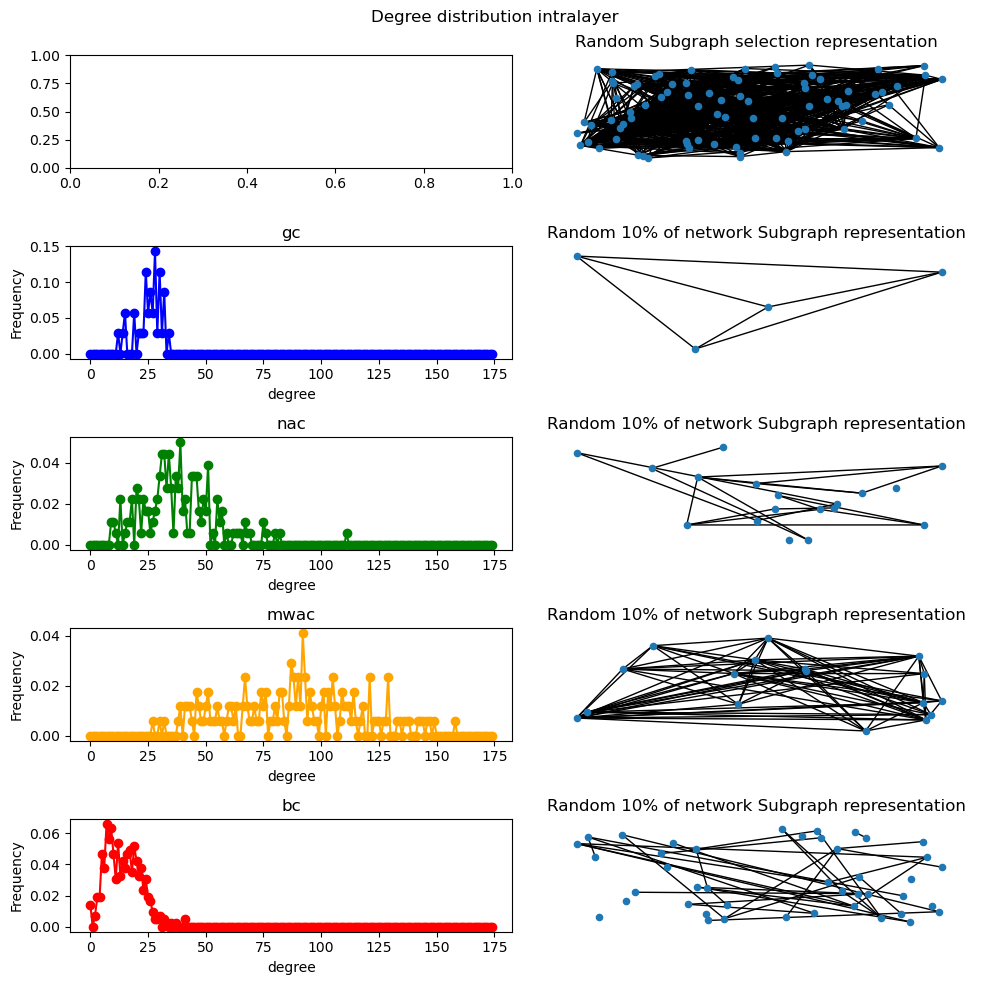

In [22]:
fig_degree_distrib,axs = plt.subplots(5,2,figsize=(10,10))
AxesF=axs.flat

## Monolayer
#global_deg_f=np.zeros((575))
#deg_f = nx.degree_histogram(Final_wG)
#global_deg_f[0:len(deg_f)]=np.array(deg_f)/Final_wG.number_of_nodes()
#k = range(len(global_deg_f))
#AxesF[0].plot(k, global_deg_f,color='black') 
#AxesF[0].set_title('Monolayer Representation')
#AxesF[0].set(xlabel='degree',ylabel='Frequency')

rdm_n_sel=random.sample(list(Final_wG.nodes()),round(Final_wG.number_of_nodes()*0.1))
subsubg=Final_wG.subgraph(rdm_n_sel)
nx.draw(subsubg,ax=AxesF[1],node_size=20,pos=nx.random_layout(subsubg))
AxesF[1].set_title('Random Subgraph selection representation ')

## Multilayer
for i,lay_i in enumerate(All_limit_of_interest):
    global_deg_f=np.zeros((175))
    name_lay_i=All_limit_of_interest_name[i]
    subg=All_adj_sub_M[name_lay_i+'_'+name_lay_i+'_graph']
    deg_f = nx.degree_histogram(subg)
    global_deg_f[0:len(deg_f)]=np.array(deg_f)/subg.number_of_nodes()
    k = range(len(global_deg_f))
    AxesF[2*(i)+2].plot(k, global_deg_f,'o-',color=Colors_l[i]) 
    AxesF[2*(i)+2].set_title(name_lay_i)
    AxesF[2*(i)+2].set(xlabel='degree',ylabel='Frequency')
    rdm_n_sel=random.sample(list(subg.nodes()),round(subg.number_of_nodes()*0.1))
    subsubg=subg.subgraph(rdm_n_sel)
    nx.draw(subsubg,ax=AxesF[2*(i)+1+2],node_size=20,pos=nx.random_layout(subsubg))
    AxesF[2*(i)+1+2].set_title('Random 10% of network Subgraph representation ')

fig_degree_distrib.suptitle('Degree distribution intralayer') 
fig_degree_distrib.tight_layout() 


4it [00:00, 18.14it/s]


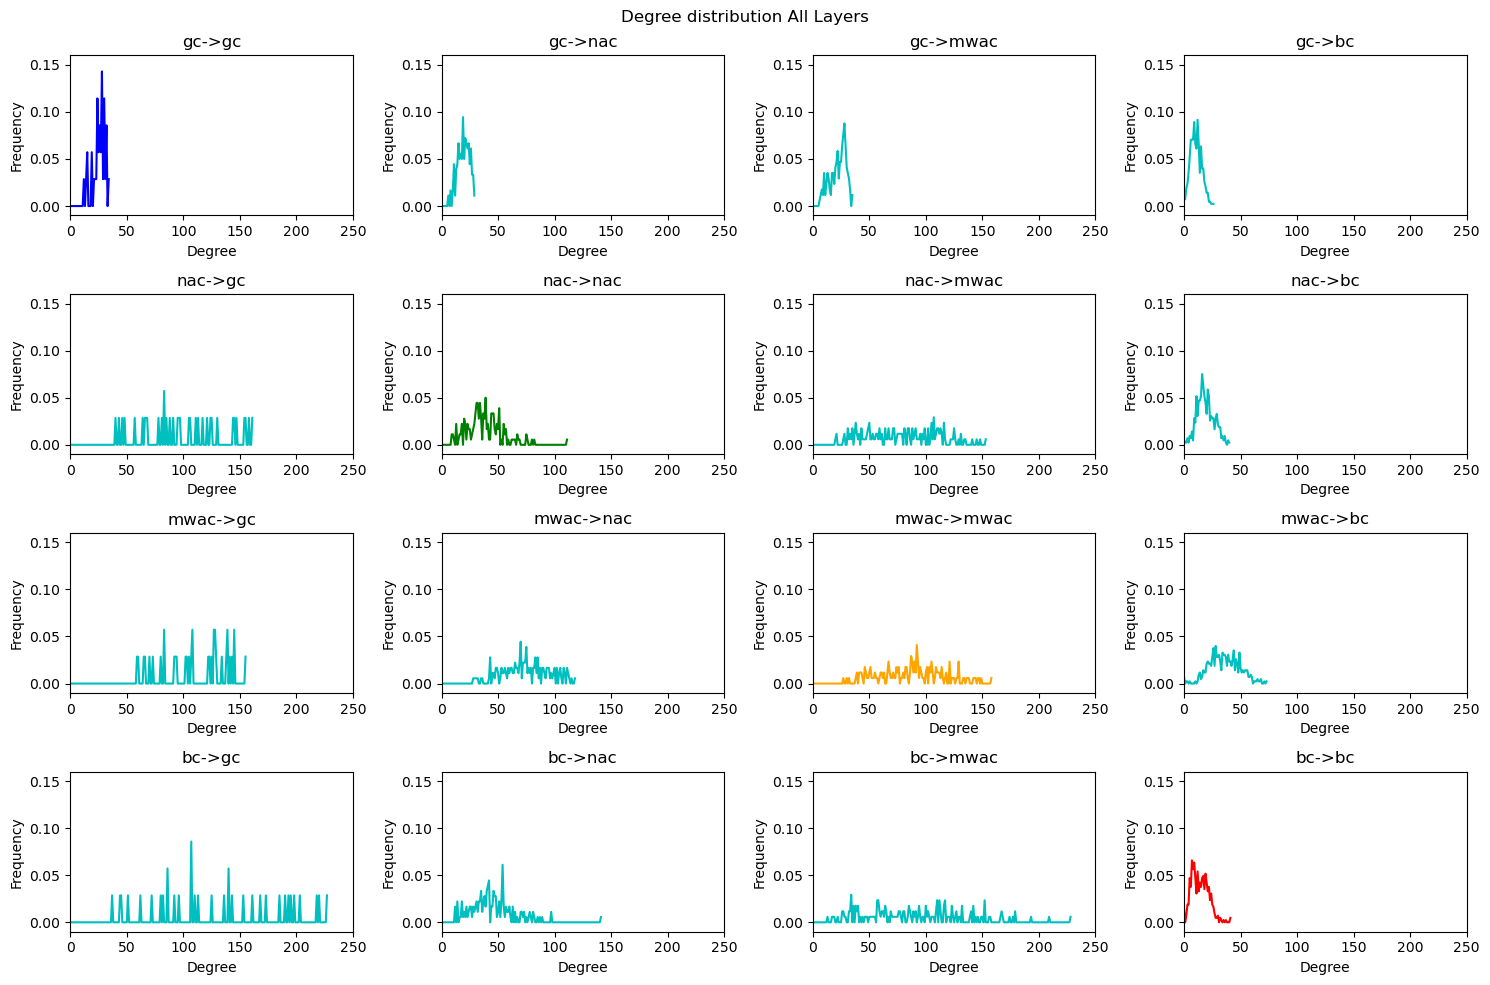

In [23]:
xlim=(0,250)
ylim=(-0.01,0.16)

Name_plt='Degree'
xlab='Degree'

fig_all_deg_distrib,axs = plt.subplots(4,4,figsize=(15,10))
#AxesF=axs.flat
for i,lay_i in tqdm(enumerate(All_limit_of_interest)):
    for j,lay_j in enumerate(All_limit_of_interest):
        if lay_i==lay_j:
            col=Colors_l[i]
        else:
            col='c'
        if lay_i<=lay_j:
            name_lay_i=All_limit_of_interest_name[i]
            name_lay_j=All_limit_of_interest_name[j]
            adj_weig_subg=np.squeeze(np.array(All_adj_sub_M[name_lay_i+'_'+name_lay_j+'_matrice'].todense()))
            adj_NW_subg=Transform_binary_mat(adj_weig_subg)
            ls_deg=np.sum(adj_NW_subg,axis=0)
        if lay_i>lay_j:
            name_lay_i=All_limit_of_interest_name[i]
            name_lay_j=All_limit_of_interest_name[j]
            adj_weig_subg=np.squeeze(np.array(All_adj_sub_M[name_lay_j+'_'+name_lay_i+'_matrice'].todense())).T
            adj_NW_subg=Transform_binary_mat(adj_weig_subg)
            ls_deg=np.sum(adj_NW_subg,axis=0)
        global_deg_f=Degree_hist_Weight(ls_deg)
        k = range(len(global_deg_f))

        axs[i][j].plot(k, global_deg_f,'-',color=col) 
        axs[i][j].set_title(name_lay_i+'->'+name_lay_j)
        axs[i][j].set(xlabel=xlab,ylabel='Frequency')
        axs[i][j].set_xlim(xmin=xlim[0],xmax=xlim[1])
        axs[i][j].set_ylim(ymin=ylim[0],ymax=ylim[1])
        
fig_all_deg_distrib.suptitle(Name_plt+' distribution All Layers') 
fig_all_deg_distrib.tight_layout() 

## Strength Distribution

4it [00:00, 20.47it/s]


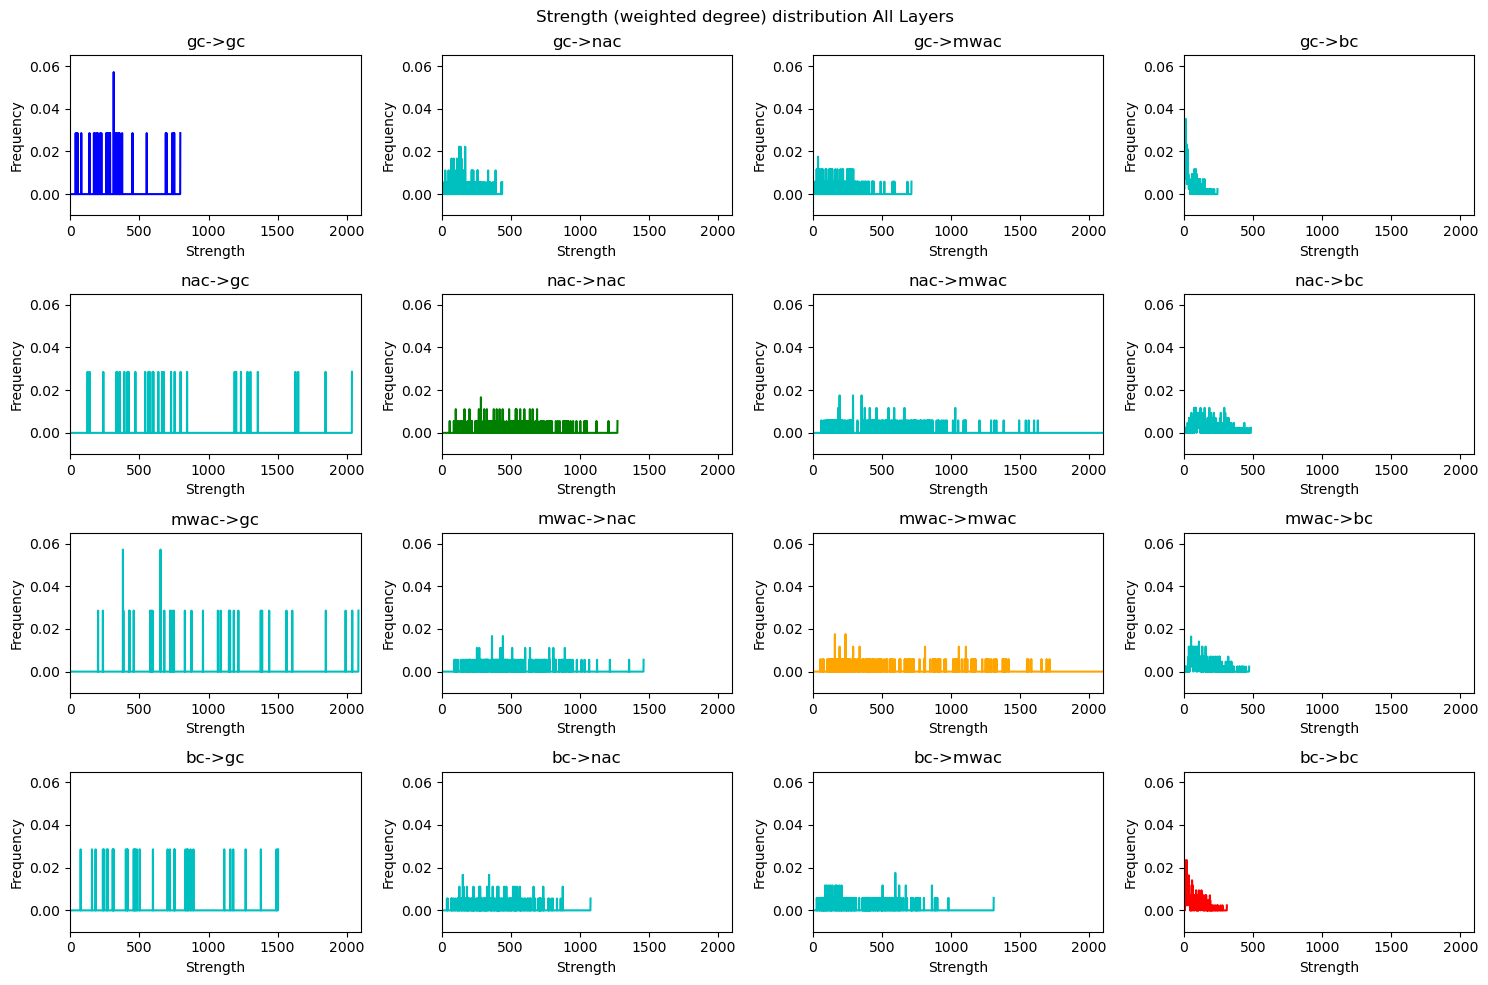

In [24]:
xlim=[-0.1,2100]
ylim=[-0.01,0.065]

Name_plt='Strength (weighted degree)'
xlab='Strength'

fig_all_deg_distrib,axs = plt.subplots(4,4,figsize=(15,10))
#AxesF=axs.flat
for i,lay_i in tqdm(enumerate(All_limit_of_interest)):
    for j,lay_j in enumerate(All_limit_of_interest):
        if lay_i==lay_j:
            col=Colors_l[i]
        else:
            col='c'
        if lay_i<=lay_j:
            name_lay_i=All_limit_of_interest_name[i]
            name_lay_j=All_limit_of_interest_name[j]
            adj_weig_subg=np.squeeze(np.array(All_adj_sub_M[name_lay_i+'_'+name_lay_j+'_matrice'].todense()))
            adj_NW_subg=Transform_binary_mat(adj_weig_subg)
            ls_deg=np.sum(adj_weig_subg,axis=0)
        if lay_i>lay_j:
            name_lay_i=All_limit_of_interest_name[i]
            name_lay_j=All_limit_of_interest_name[j]
            adj_weig_subg=np.squeeze(np.array(All_adj_sub_M[name_lay_j+'_'+name_lay_i+'_matrice'].todense())).T
            adj_NW_subg=Transform_binary_mat(adj_weig_subg)
            ls_deg=np.sum(adj_weig_subg,axis=0)
                
        global_deg_f=Degree_hist_Weight(ls_deg)
        k = range(len(global_deg_f))
        axs[i][j].plot(k, global_deg_f,color=col) 
        axs[i][j].set_title(name_lay_i+'->'+name_lay_j)
        axs[i][j].set(xlabel=xlab,ylabel='Frequency')
        axs[i][j].set_xlim(xmin=xlim[0],xmax=xlim[1])
        axs[i][j].set_ylim(ymin=ylim[0],ymax=ylim[1])
        
fig_all_deg_distrib.suptitle(Name_plt+' distribution All Layers') 
fig_all_deg_distrib.tight_layout() 


## Overlapping degree


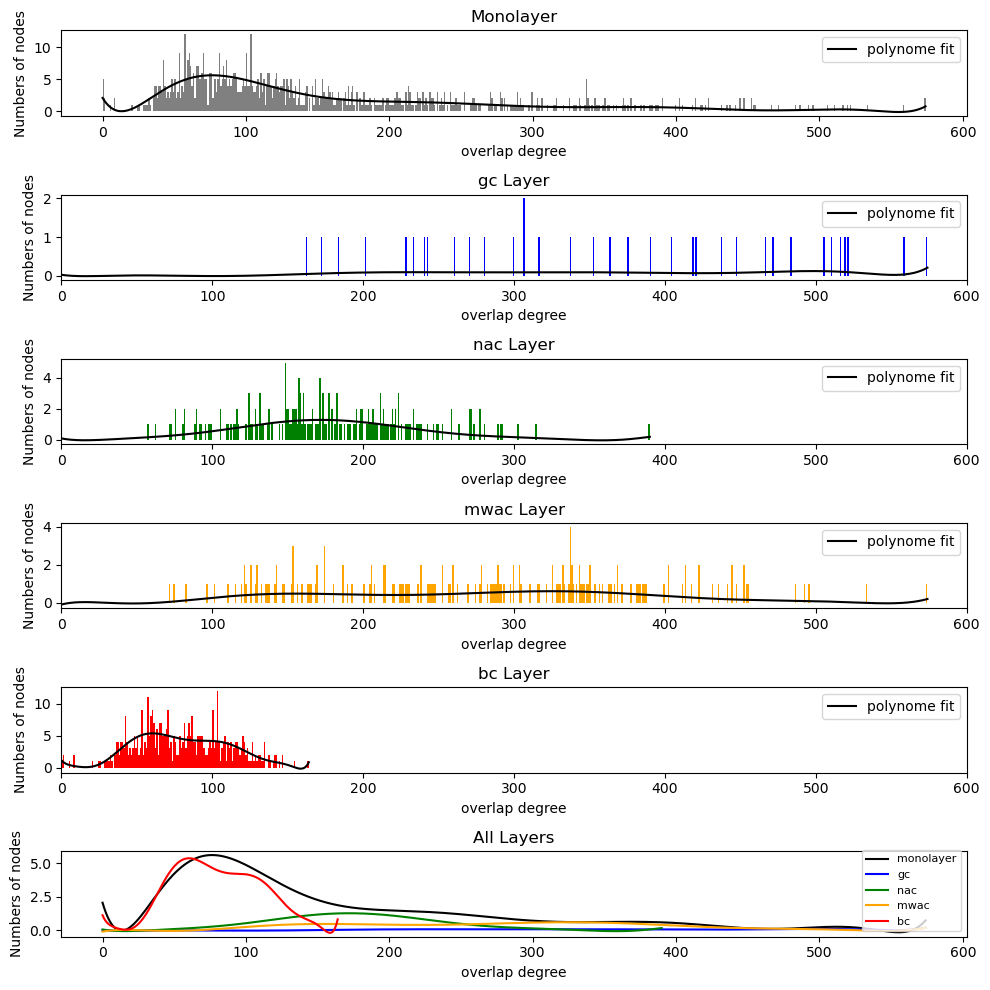

In [25]:
Sum_over_nodes_and_Layers=np.sum(Final_super_adj_mat_Binary,axis=0)

fig_overlap_degree_distrib,axs = plt.subplots(6,1,figsize=(10,10))

global_deg_f=Degree_hist_Weight(Sum_over_nodes_and_Layers.astype(int))*len(Sum_over_nodes_and_Layers)
k = range(len(global_deg_f))
#plt.plot(k, global_deg_f,'go-') 

poly = np.polyfit(k, global_deg_f,10)
poly_y = np.poly1d(poly)(k)
#axs[0].plot(k, global_deg_f, color='black')
axs[0].plot(k,poly_y, color='black',label='polynome fit')
axs[0].set_title('Monolayer')
axs[0].hist(Sum_over_nodes_and_Layers,bins=k,color='gray')
axs[0].set(ylabel='Numbers of nodes',xlabel='overlap degree')
axs[-1].plot(k,poly_y, color='black',label='monolayer')
axs[-1].set(ylabel='Numbers of nodes',xlabel='overlap degree')
axs[0].legend()
for i,lay in enumerate(All_limit_of_interest):
    global_deg_f=Degree_hist_Weight(Sum_over_nodes_and_Layers[lay[0]-1:lay[1]-1].astype(int))
    global_deg_f=global_deg_f*len(Sum_over_nodes_and_Layers[lay[0]-1:lay[1]-1])
    k = range(len(global_deg_f))
    poly = np.polyfit(k, global_deg_f,10)
    poly_y = np.poly1d(poly)(k)
    axs[i+1].plot(k,poly_y, color='black',label='polynome fit')
    axs[i+1].legend()
    #axs[i+1].plot(k,global_deg_f, color=Colors_l[i])
    axs[i+1].set_title(All_limit_of_interest_name[i]+' Layer')
    axs[i+1].hist(Sum_over_nodes_and_Layers[lay[0]-1:lay[1]-1].astype(int),bins=k,color=Colors_l[i])
    axs[i+1].set(ylabel='Numbers of nodes',xlabel='overlap degree')
    axs[i+1].set_xlim(xmin=0,xmax=600)
    axs[-1].plot(k,poly_y, color=Colors_l[i],label=All_limit_of_interest_name[i])
axs[-1].set_title('All Layers')
axs[-1].legend(prop={'size': 8})
fig_overlap_degree_distrib.tight_layout() 

## Rich Club

In [28]:
def dict_to_mat_RC(dic):
    Mat=np.zeros((len(dic),len(dic[0])))
    for i in range(len(dic)):
        for j in range(29):
            Mat[i,j]=dic[i][j]
    return Mat

def return_rich_club_coeff_norm_graph(Graphe,Nbrs_graph):
    Gra=Graphe.copy()# to avoid modifying the graph later with edge swap 
    dict_rc=nx.rich_club_coefficient(Gra, normalized=False)
    arr_rc=np.array(list(dict_rc.items()))[:,1]

    n_swa=random.sample(range(len(list(Gra.edges())),3*len(list(Gra.edges()))),Nbrs_graph) # Select randomly 
    #nbrs swap as there exist numbers of edges
    List_swap_model=[nx.double_edge_swap(Gra, nswap=n_swa[i], max_tries=n_swa[i]*100).copy() for i in tqdm(range(Nbrs_graph),position=0, leave=True)]
    dict_rc_swap_model=[nx.rich_club_coefficient(conf_i, normalized=False) for conf_i in List_swap_model]
    DF_rc_swap_model=pd.DataFrame(dict_rc_swap_model).T
    Avg_rc_swap_m=DF_rc_swap_model.mean(axis=1)

    Normalized_rc=[arr_rc[i]/(Avg_rc_swap_m[i]) for i in range(len(Avg_rc_swap_m))]

    return Normalized_rc,Avg_rc_swap_m,arr_rc,DF_rc_swap_model,List_swap_model,n_swa


def return_rich_club_coeff_norm_adj_mat(Mat,Nbrs_graph):
    Bin_mat=Transform_binary_mat(Mat).copy() # copy to avoid modifiyng the original
    if Mat.shape[0]==Mat.shape[1]: # case squared matrix
        graph = nx.from_numpy_array(Bin_mat)
        Normalized_rc,Avg_rc_swap_m,arr_rc,rc_swap_model,List_swap_model,n_swa=return_rich_club_coeff_norm_graph(graph,Nbrs_graph)
    else:
        arr_rc=Mat_RC_Algo(Bin_mat)
    
        n_swa=random.sample(range(int(np.sum(Bin_mat)),int(3*np.sum(Bin_mat))),Nbrs_graph) # Random nbrs of swap 
        #in Total numbers of edges
        List_swap_model=[Mat_D_E_S_Algo(Bin_mat,nswap=n_swa[i], max_tries=n_swa[i]*100).copy() for i in tqdm(range(Nbrs_graph),position=0, leave=True)]
        rc_swap_model=[Mat_RC_Algo(m_i) for m_i in List_swap_model]
        Avg_rc_swap_m=np.average(rc_swap_model,axis=0)
    
        Normalized_rc=[arr_rc[i]/Avg_rc_swap_m[i] for i in range(len(Avg_rc_swap_m))]
    
    return Normalized_rc,Avg_rc_swap_m,arr_rc,rc_swap_model,List_swap_model,n_swa

def Mat_RC_Algo(mat_t):
    Deg_x=np.sum(mat_t,axis=1)
    Deg_y=np.sum(mat_t,axis=0)
    Max_deg=max([int(max(Deg_x)),int(max(Deg_y.T))])
    RC=[]
    for k_i in range(Max_deg): # want to surpass max_deg
        Bool_deg_x=Deg_x>k_i
        Bool_deg_y=Deg_y>k_i
        Nkx=int(sum(Bool_deg_x))
        Nky=int(sum(Bool_deg_y.T))
        Nk=Nkx+Nky
        Ek=int(np.matmul(np.matmul(Bool_deg_x.T,mat_t),Bool_deg_y.T))
        if mat_t.shape[0] == mat_t.shape[1]:
            #divide by 2 because edges are counted 2 times (Adj matrix is symmetric)
            Nk=Nk/2
            Ek=Ek/2
        if Ek>0:
            RC.append(2*Ek/(Nk*(Nk-1)))
    return RC

def Mat_D_E_S_Algo(mat_T, nswap=1, max_tries=100, seed=None):
## BASED ON NETWORKX Function

    swapcount=0
    n=0
    deg_list_L1=np.array(np.sum(mat_T,axis=0))#[0]
    #print('deg_l1',deg_list_L1)
    cdf_L1 = nx.utils.cumulative_distribution(deg_list_L1)  # cdf of degree
    
    deg_list_L2=np.array(np.sum(mat_T,axis=1)).T#[0]
    #print('deg_l2',deg_list_L2)
    cdf_L2 = nx.utils.cumulative_distribution(deg_list_L2)  # cdf of degree
    
    discrete_sequence = nx.utils.discrete_sequence
    
    sz_L2,sz_L1=mat_T.shape
    idx_L1=np.array(range(sz_L1))
    idx_L2=np.array(range(sz_L2))
    
    while swapcount < nswap:
    
        # the index correspond directly to the label
        # Select u in L1 and x in L2
        u= discrete_sequence(1, cdistribution=cdf_L1) #Return sample sequence of length n=1 from a given discrete 
        #distribution or discrete cumulative distribution
        x= discrete_sequence(1, cdistribution=cdf_L2) 
        
        
        #print('u,x',u,x)
        if mat_T[x,u]==1:
            #print('x',x,mat_T[x,:])
            #print('u',u,mat_T[:,u])
            continue # skip
        
        inter_neigh_u=idx_L2[np.array(mat_T)[:,u].astype('bool').T[0]] # neighboors of u in the layer 2 (interlayer
        #neighboor)
        inter_neigh_x=idx_L1[np.array(mat_T)[x,:].astype('bool')[0]]
        
        #print('inter_neigh_x',inter_neigh_x)
        #print('inter_neigh_u',inter_neigh_u)
        
        v = random.choice(inter_neigh_x) # since it is interlayer neighboor, x will gives a neigh on layer 1 
        #compused of (u,v,w,...)
        y = random.choice(inter_neigh_u) # since it is interlayer neighboor, u will gives a neigh on layer 1 
        #compused of (x,y,z,...)
        
        #print('v,y',v,y)
        
        if n >= max_tries:
                e = (
                    f"Maximum number of swap attempts ({n}) exceeded "
                    f"before desired swaps achieved ({nswap})."
                )
        if mat_T[y,v]!=1: # No parallel edges if the new connection already exist
            mat_T[x,v]=0
            mat_T[y,u]=0
            mat_T[x,u]=1
            mat_T[y,v]=1  
            swapcount += 1
            #print('Yes',swapcount)
            if swapcount==1:
                mat_inte=mat_T.copy()
        else:
            #print('y',y,mat_T[y,:])
            #print('v',v,mat_T[:,v])  # No parallel edges
            continue # skip
        if n >= max_tries:
                e = (
                    f"Maximum number of swap attempts ({n}) exceeded "
                    f"before desired swaps achieved ({nswap})."
                )
        n=+1
        
    return mat_T


In [29]:
Nbrs_graph=20
ALL_RC={'RC_normal':[],'RC_av_swap':[],'RC_subg':[],'RC_all_swap':[]}
ALL_list_model={'model':[],'Nbrs_Swap':[]}

for i,lay_i in enumerate(All_limit_of_interest):
    name_lay_i=All_limit_of_interest_name[i]
    subg=All_adj_sub_M[name_lay_i+'_'+name_lay_i+'_graph']  
    RC_normal,RC_av_swap,RC_subg,RC_all_sw,list_model,nswa=return_rich_club_coeff_norm_graph(subg,Nbrs_graph)
    ALL_RC['RC_normal'].append(RC_normal)
    ALL_RC['RC_av_swap'].append(RC_av_swap)
    ALL_RC['RC_subg'].append(RC_subg)
    ALL_RC['RC_all_swap'].append(RC_all_sw)

    ALL_list_model['model'].append(list_model)
    ALL_list_model['Nbrs_Swap'].append(nswa)
    
RC_normal_monoL,RC_av_swap_monoL,RC_subg_monoL,RC_all_swap_monoL,list_m_monoL,num_swa_monoL=return_rich_club_coeff_norm_graph(G,Nbrs_graph)


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [03:46<00:00, 11.35s/it]


In [30]:
ALL_RC_mat={'RC_normal':[],'RC_av_swap':[],'RC_subg':[],'RC_all_swap':[]}
ALL_list_model_mat={'model':[],'Nbrs_Swap':[]}
for i,lay_i in tqdm(enumerate(All_limit_of_interest)):
    for j,lay_j in enumerate(All_limit_of_interest):
        if lay_i<=lay_j:
            name_lay_i=All_limit_of_interest_name[i]
            name_lay_j=All_limit_of_interest_name[j]
            adj_weig=np.squeeze(np.array(All_adj_sub_M[name_lay_i+'_'+name_lay_j+'_matrice'].todense()))
            adj_NW_mat=Transform_binary_mat(adj_weig)
        if lay_i>lay_j:
            name_lay_i=All_limit_of_interest_name[i]
            name_lay_j=All_limit_of_interest_name[j]
            adj_weig=np.squeeze(np.array(All_adj_sub_M[name_lay_j+'_'+name_lay_i+'_matrice'].todense())).T
            adj_NW_mat=Transform_binary_mat(adj_weig)
        RC_normal,RC_av_swap,RC_mat,RC_all_sw,list_model,nswa=return_rich_club_coeff_norm_adj_mat(adj_weig,Nbrs_graph)
        ALL_RC_mat['RC_normal'].append(RC_normal)
        ALL_RC_mat['RC_av_swap'].append(RC_av_swap)
        ALL_RC_mat['RC_subg'].append(RC_mat)
        ALL_RC_mat['RC_all_swap'].append(RC_all_sw)

        ALL_list_model_mat['model'].append(list_model)
        ALL_list_model_mat['Nbrs_Swap'].append(nswa)


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:16<00:00,  1.21it/s]
4it [14:59:05, 13486.28s/it]


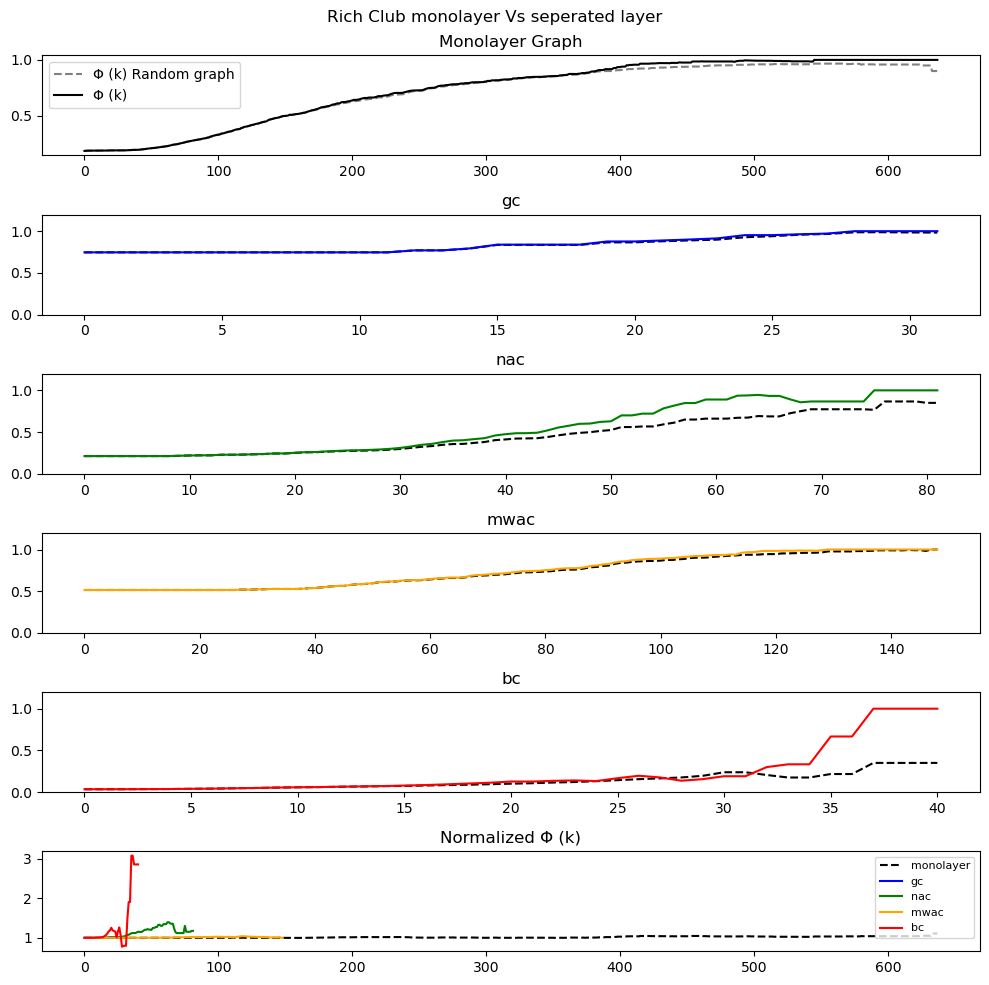

In [31]:
fig_rich_club_layer,axs = plt.subplots(6,1,figsize=(10,10))


k=range(len(RC_normal_monoL))
axs[0].plot(k, RC_av_swap_monoL,'--',color='gray',label='\u03A6 (k) Random graph') 
axs[0].plot(k, RC_subg_monoL,color='black',label='\u03A6 (k)')
axs[0].set_title('Monolayer Graph')
axs[0].legend()
axs[-1].plot(k, RC_normal_monoL,'--',color='black',label='monolayer') 

#axs[-1].plot(k, RC_subg_monoL,color='black',label='monolayer') 

for i,lay_i in enumerate(All_limit_of_interest):
    name_lay_i=All_limit_of_interest_name[i]
    RC_normal=ALL_RC['RC_normal'][i]
    RC_av_swap=ALL_RC['RC_av_swap'][i]
    RC_subg=ALL_RC['RC_subg'][i]

    k=range(len(RC_normal))
    axs[i+1].plot(k, RC_av_swap,'--',color='black') 
    axs[i+1].plot(k, RC_subg,color=Colors_l[i])
    axs[-1].plot(k, RC_normal,color=Colors_l[i],label=name_lay_i)
    axs[i+1].set_title(name_lay_i)
    #axs[-1].plot(k, RC_subg,color=Colors_l[i],label=name_lay_i)
    #axs[i+1].set(xlabel='Strength (Weighted degree)',ylabel='Frequency')
    axs[i+1].set_ylim(0,1.2)

axs[-1].set_title('Normalized \u03A6 (k)')
#axs[-1].set_xlim(0,60)
#axs[-1].set_ylim(0.9,2)

axs[-1].legend(prop={'size': 8})

fig_rich_club_layer.suptitle('Rich Club monolayer Vs seperated layer') 
fig_rich_club_layer.tight_layout() 
plt.show()


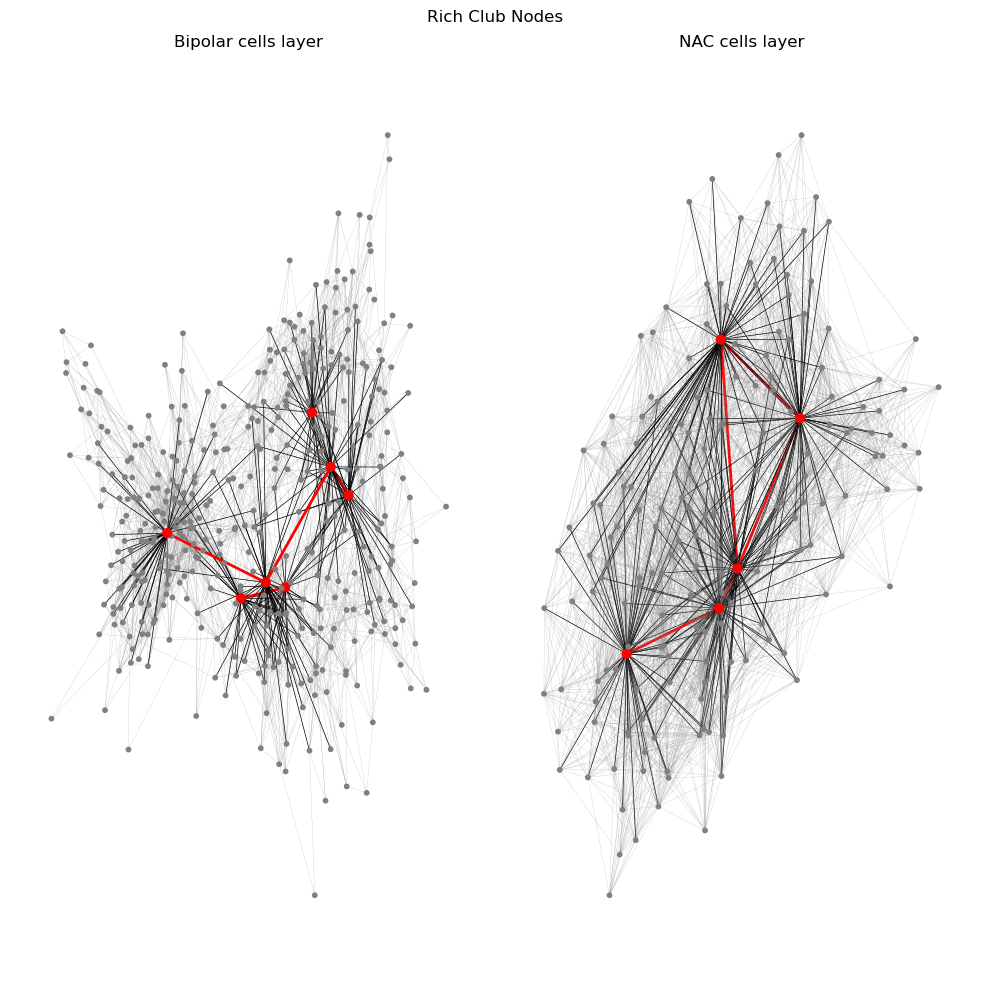

In [32]:
fig_rich_club_nodes,axs = plt.subplots(1,2,figsize=(10,10))
bc_rich_club_deg_min=32
nac_rich_club_deg_interval=[58,65]
# bc
Subg_bc_all_comp = [All_adj_sub_M['bc_bc'+'_graph'].subgraph(comp).copy() for comp in nx.connected_components(All_adj_sub_M['bc_bc'+'_graph'])]
subg_all_bc=Subg_bc_all_comp[0]
bc_node_rc=[n_i for n_i,k_i in subg_all_bc.degree() if k_i>=bc_rich_club_deg_min]
color_map_bc=[]
node_sz_bc=[]
edge_color_bc=[]
width_bc=[]
for n_i,k_i in subg_all_bc.degree():
    if k_i>=bc_rich_club_deg_min:
        color_map_bc.append('red')
        node_sz_bc.append(40)
        
    else:
        color_map_bc.append('gray')
        node_sz_bc.append(10)
for e_i in subg_all_bc.edges(data=False):
    if e_i[0] in bc_node_rc or e_i[1] in bc_node_rc:
        if e_i[0] in bc_node_rc and e_i[1] in bc_node_rc:
            edge_color_bc.append('red')
            width_bc.append(2)
        else:
            edge_color_bc.append('black')
            width_bc.append(0.5)
    else:
        edge_color_bc.append('gray')
        width_bc.append(0.1)
nx.draw(subg_all_bc, node_color=color_map_bc,ax=axs[0],node_size=node_sz_bc,pos=nx.spring_layout(subg_all_bc),
        edge_color=edge_color_bc,width=width_bc)
axs[0].set_title('Bipolar cells layer')

# nac
Subg_nac_all_comp = [All_adj_sub_M['nac_nac'+'_graph'].subgraph(comp).copy() for comp in nx.connected_components(All_adj_sub_M['nac_nac'+'_graph'])]
subg_all_nac=Subg_nac_all_comp[0]
nac_node_rc=[n_i for n_i,k_i in subg_all_nac.degree() if k_i>=nac_rich_club_deg_interval[0] and k_i<=nac_rich_club_deg_interval[1] ]
color_map_nac=[]
node_sz_nac=[]
edge_color_nac=[]
width_nac=[]
for n_i,k_i in subg_all_nac.degree():
    if k_i>=nac_rich_club_deg_interval[0] and k_i<=nac_rich_club_deg_interval[1]:
        color_map_nac.append('red')
        node_sz_nac.append(40)
    else:
        color_map_nac.append('gray')
        node_sz_nac.append(10)
for e_i in subg_all_nac.edges(data=False):
    if e_i[0] in nac_node_rc or e_i[1] in nac_node_rc:
        if e_i[0] in nac_node_rc and e_i[1] in nac_node_rc:
            edge_color_nac.append('red')
            width_nac.append(2)
        else:
            edge_color_nac.append('black')
            width_nac.append(0.5)
    else:
        edge_color_nac.append('gray')
        width_nac.append(0.1)
nx.draw(subg_all_nac, node_color=color_map_nac,ax=axs[1],node_size=node_sz_nac,pos=nx.spring_layout(subg_all_nac),
        edge_color=edge_color_nac,width=width_nac)
axs[1].set_title('NAC cells layer')

fig_rich_club_nodes.suptitle('Rich Club Nodes') 
fig_rich_club_nodes.tight_layout() 
#print('NAC RC',[id_i+nac_layer[0] for id_i in nac_node_rc])
#print('BC RC',[id_i+bc_newlay[0] for id_i in bc_node_rc])

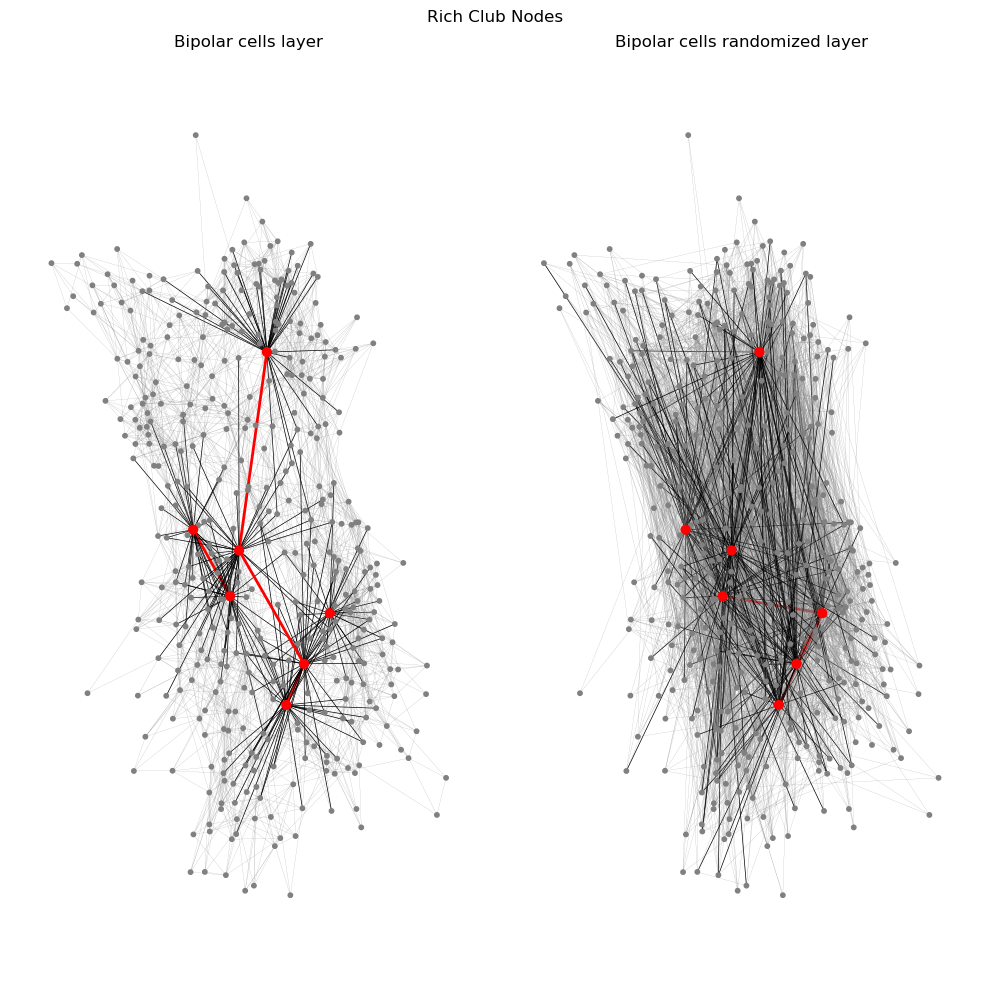

In [52]:
fig_rich_club_nodes,axs = plt.subplots(1,2,figsize=(10,10))
bc_rich_club_deg_min=32
# bc
Subg_bc_all_comp = [All_adj_sub_M['bc_bc'+'_graph'].subgraph(comp).copy() for comp in nx.connected_components(All_adj_sub_M['bc_bc'+'_graph'])]
subg_all_bc=Subg_bc_all_comp[0]
bc_node_rc=[n_i for n_i,k_i in subg_all_bc.degree() if k_i>=bc_rich_club_deg_min]
color_map_bc=[]
node_sz_bc=[]
edge_color_bc=[]
width_bc=[]
Posi=nx.spring_layout(subg_all_bc)

for n_i,k_i in subg_all_bc.degree():
    if k_i>=bc_rich_club_deg_min:
        color_map_bc.append('red')
        node_sz_bc.append(40)
        
    else:
        color_map_bc.append('gray')
        node_sz_bc.append(10)
for e_i in subg_all_bc.edges(data=False):
    if e_i[0] in bc_node_rc or e_i[1] in bc_node_rc:
        if e_i[0] in bc_node_rc and e_i[1] in bc_node_rc:
            edge_color_bc.append('red')
            width_bc.append(2)
        else:
            edge_color_bc.append('black')
            width_bc.append(0.5)
    else:
        edge_color_bc.append('gray')
        width_bc.append(0.1)
nx.draw(subg_all_bc, node_color=color_map_bc,ax=axs[0],node_size=node_sz_bc,pos=Posi,edge_color=edge_color_bc,width=width_bc)
axs[0].set_title('Bipolar cells layer')
# bc randomized
rdm_g=random.choice(ALL_list_model['model'][-1][5:6])
Subg_bc2_all_comp = [rdm_g.subgraph(comp).copy() for comp in nx.connected_components(rdm_g)]
subg_all_bc2=Subg_bc2_all_comp[0]
bc_node_rc2=[n_i for n_i,k_i in subg_all_bc2.degree() if k_i>=bc_rich_club_deg_min]
color_map_bc2=[]
node_sz_bc2=[]
edge_color_bc2=[]
width_bc2=[]
for n_i,k_i in subg_all_bc2.degree():
    if k_i>=bc_rich_club_deg_min:
        color_map_bc2.append('red')
        node_sz_bc2.append(40)
        
    else:
        color_map_bc2.append('gray')
        node_sz_bc2.append(10)
for e_i in subg_all_bc2.edges(data=False):
    if e_i[0] in bc_node_rc2 or e_i[1] in bc_node_rc2:
        if e_i[0] in bc_node_rc2 and e_i[1] in bc_node_rc2:
            edge_color_bc2.append('red')
            width_bc2.append(2)
        else:
            edge_color_bc2.append('black')
            width_bc2.append(0.5)
    else:
        edge_color_bc2.append('gray')
        width_bc2.append(0.1)
nx.draw(subg_all_bc2, node_color=color_map_bc2,ax=axs[1],node_size=node_sz_bc2,pos=Posi,edge_color=edge_color_bc2,
        width=width_bc2)
axs[1].set_title('Bipolar cells randomized layer')

fig_rich_club_nodes.suptitle('Rich Club Nodes') 
fig_rich_club_nodes.tight_layout() 
#print('BC2 RC',[id_i+bc_newlay[0] for id_i in bc_node_rc2])
#print('BC RC',[id_i+bc_newlay[0] for id_i in bc_node_rc])

4it [00:00, 52.90it/s]


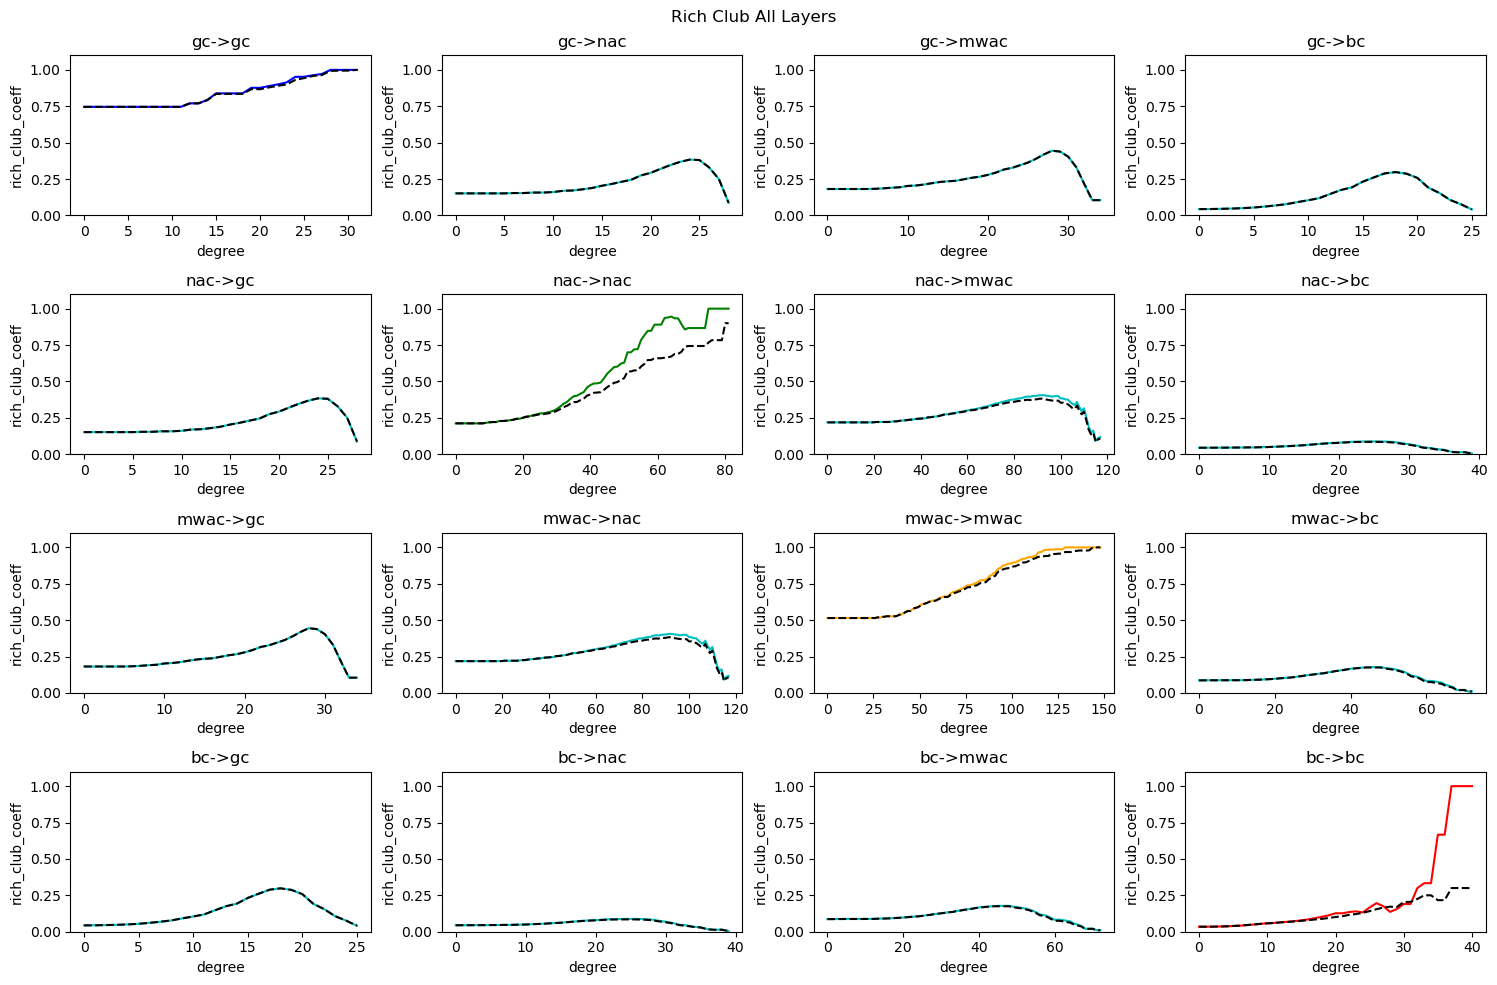

In [45]:

fig_rich_coeff,axs = plt.subplots(4,4,figsize=(15,10))
idx_dict=0
for i,lay_i in tqdm(enumerate(All_limit_of_interest)):
    for j,lay_j in enumerate(All_limit_of_interest):
        name_lay_i=All_limit_of_interest_name[i]
        name_lay_j=All_limit_of_interest_name[j]
        rc_swap=ALL_RC_mat['RC_av_swap'][idx_dict]
        rc_mat=ALL_RC_mat['RC_subg'][idx_dict]
        k = range(len(rc_mat))
        if lay_i==lay_j:
            col=Colors_l[i]
        else:
            col='c'
        axs[i][j].plot(k, rc_mat,color=col) 
        axs[i][j].plot(k, rc_swap,'--',color='black') 
        axs[i][j].set_title(name_lay_i+'->'+name_lay_j)
        axs[i][j].set(xlabel='degree',ylabel='rich_club_coeff')
        axs[i][j].set_ylim(ymin=0,ymax=1.1)
        idx_dict+=1
        
fig_rich_coeff.suptitle('Rich Club All Layers') 
fig_rich_coeff.tight_layout() 

4it [00:00, 95.72it/s]


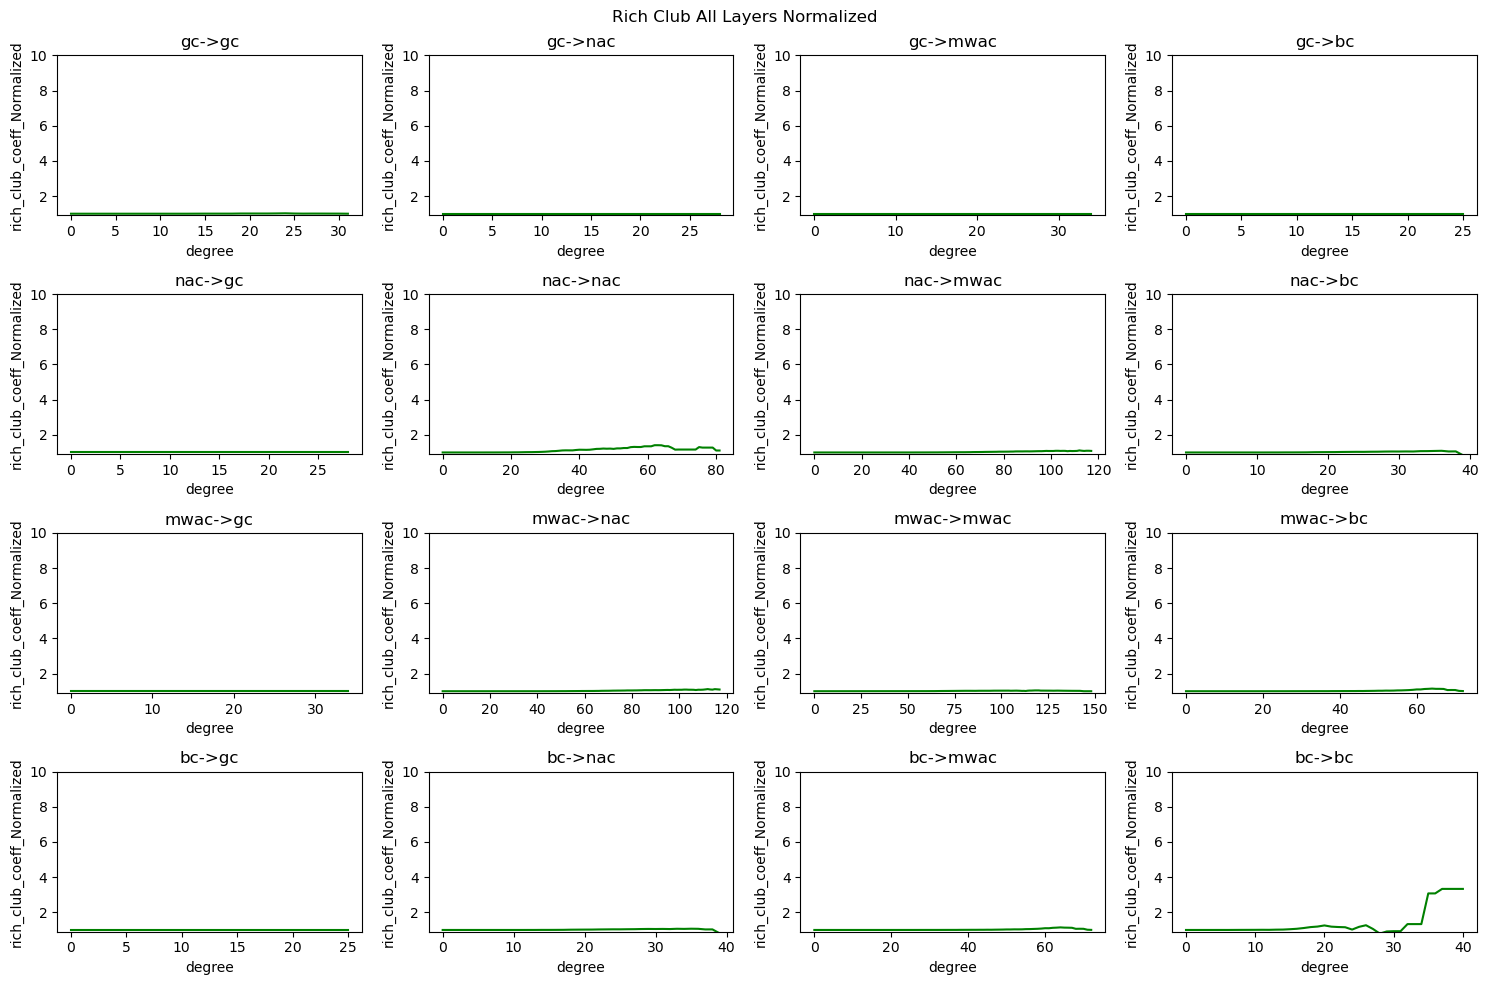

In [46]:
fig_rich_coeff_normal,axs = plt.subplots(4,4,figsize=(15,10))
idx_dict=0

for i,lay_i in tqdm(enumerate(All_limit_of_interest)):
    for j,lay_j in enumerate(All_limit_of_interest):
        name_lay_i=All_limit_of_interest_name[i]
        name_lay_j=All_limit_of_interest_name[j]
        rc_normal=ALL_RC_mat['RC_normal'][idx_dict]
        k = range(len(rc_normal))
        axs[i][j].plot(k, rc_normal,color='green') 
        axs[i][j].set_title(name_lay_i+'->'+name_lay_j)
        axs[i][j].set(xlabel='degree',ylabel='rich_club_coeff_Normalized')
        axs[i][j].set_ylim(ymin=0.9,ymax=10)
        idx_dict+=1
fig_rich_coeff_normal.suptitle('Rich Club All Layers Normalized') 
fig_rich_coeff_normal.tight_layout() 

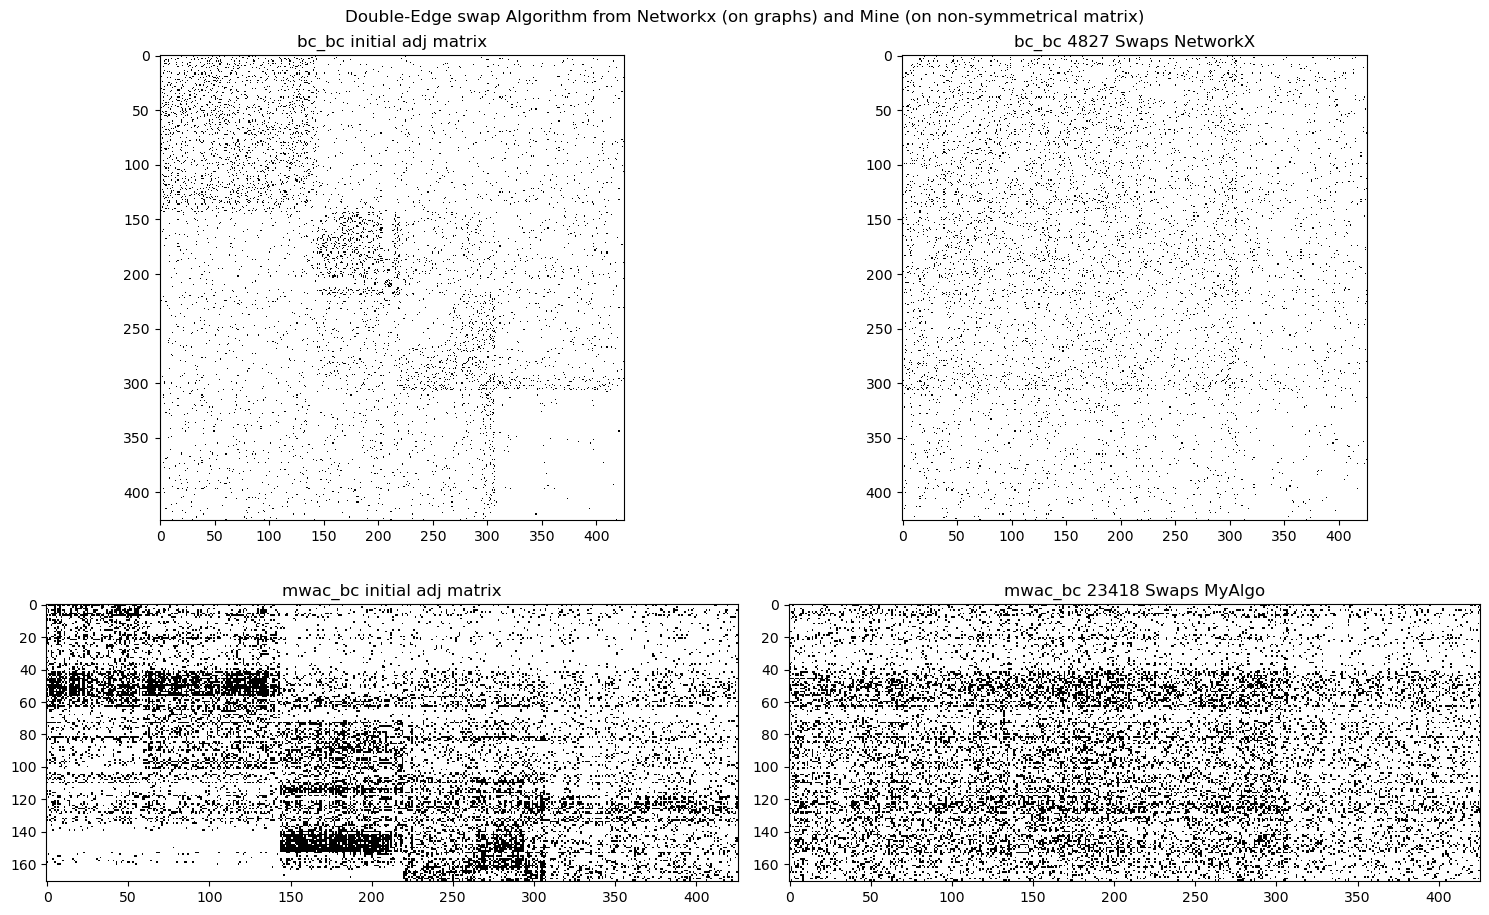

In [36]:
## Draw edge_swap matrices

Nbrs_mat_ex=1
lay_OI_1='bc_bc'
Lay_OI_1_idx=3
lay_OI_2='mwac_bc'
Lay_OI_2_idx=11

fig_double_edge_swap,axs = plt.subplots(2,1+Nbrs_mat_ex,figsize=(15,10))

random_idx=random.sample(range(Nbrs_graph),Nbrs_mat_ex)
# Graph algo
Initial_mat1=nx.adjacency_matrix(All_adj_sub_M[lay_OI_1+'_graph'],weight='None').todense()
All_other_g1=[ALL_list_model['model'][Lay_OI_1_idx][idx_i] for idx_i in random_idx]
All_swap_n=[ALL_list_model['Nbrs_Swap'][Lay_OI_1_idx][idx_i] for idx_i in random_idx]

axs[0][0].imshow(Initial_mat1, origin='upper',interpolation='nearest',cmap=plt.cm.binary)
axs[0][0].set_title(lay_OI_1+' initial adj matrix')

for i in range(Nbrs_mat_ex):
    mat_from_g=nx.adjacency_matrix((All_other_g1[i]),weight='None').todense()
    
    axs[0][i+1].imshow(mat_from_g, origin='upper',interpolation='nearest',cmap=plt.cm.binary)
    axs[0][i+1].set_title(lay_OI_1+' '+str(All_swap_n[i])+' Swaps NetworkX')

# Mat algo
Initial_mat2=Transform_binary_mat(np.squeeze(np.array(All_adj_sub_M[lay_OI_2+'_matrice'].todense())))
All_other_mat2=[ALL_list_model_mat['model'][Lay_OI_2_idx][idx_i] for idx_i in random_idx]
All_swap_n_mat2=[ALL_list_model_mat['Nbrs_Swap'][Lay_OI_2_idx][idx_i] for idx_i in random_idx]

axs[1][0].imshow(Initial_mat2, origin='upper',interpolation='nearest',cmap=plt.cm.binary)
axs[1][0].set_title(lay_OI_2+' initial adj matrix')

for i in range(Nbrs_mat_ex):
    axs[1][i+1].imshow(All_other_mat2[i], origin='upper',interpolation='nearest',cmap=plt.cm.binary)
    axs[1][i+1].set_title(lay_OI_2+' '+str(All_swap_n_mat2[i])+' Swaps MyAlgo')


fig_double_edge_swap.suptitle('Double-Edge swap Algorithm from Networkx (on graphs) and Mine (on non-symmetrical matrix)') 
fig_double_edge_swap.tight_layout() 


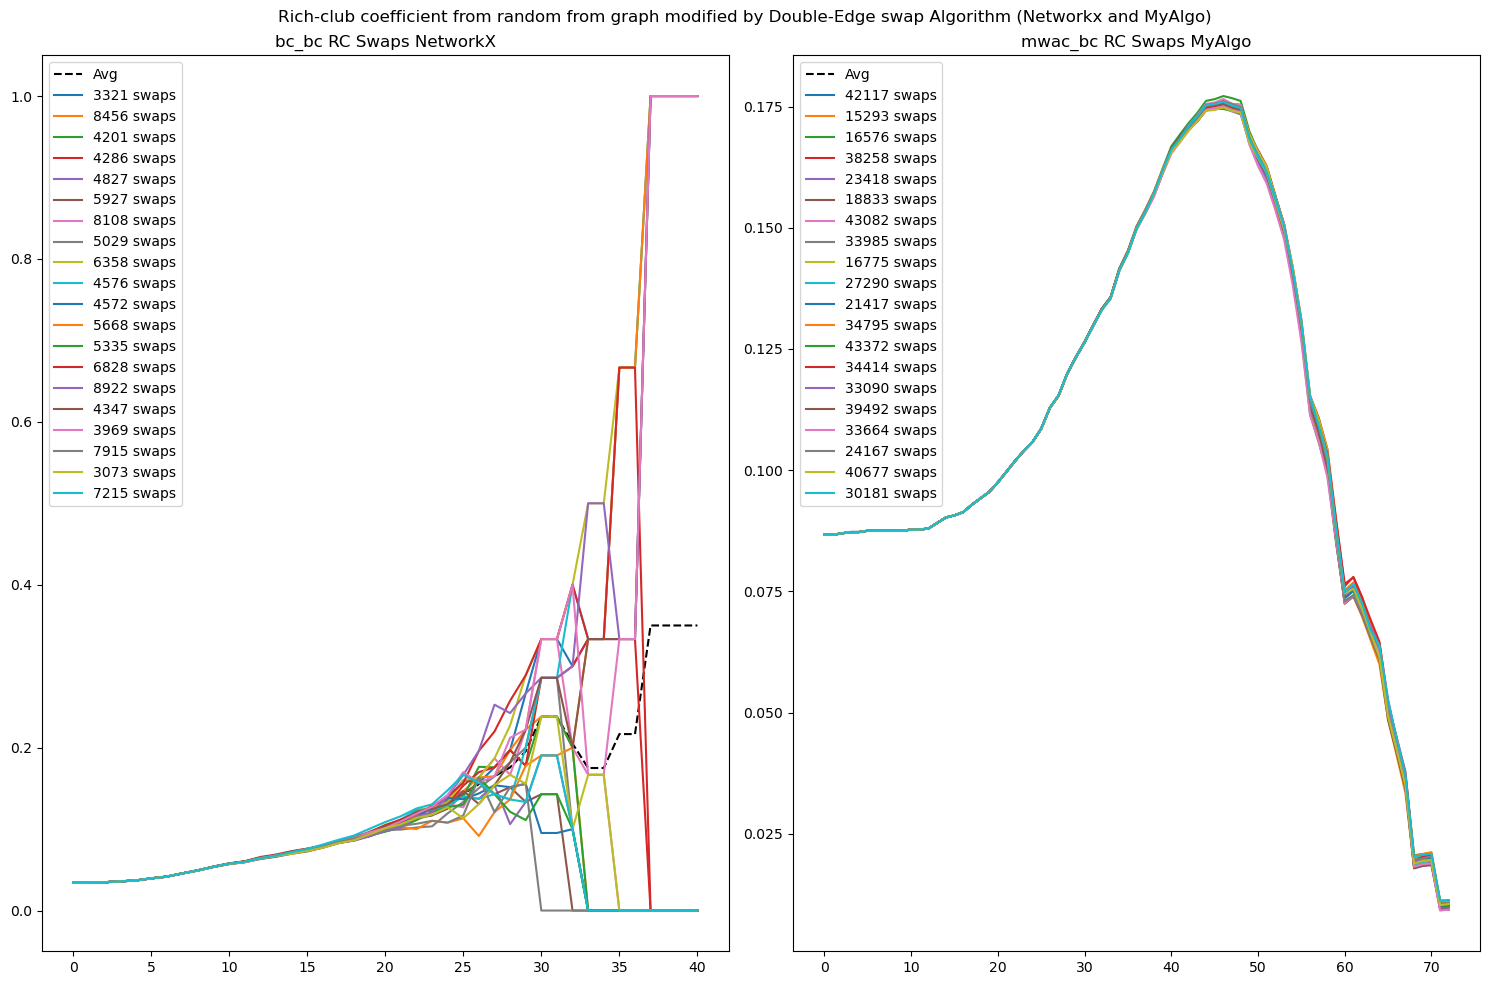

In [37]:
## Draw rc_each_swap

lay_OI_1='bc_bc'
Lay_OI_1_idx=3
lay_OI_2='mwac_bc'
Lay_OI_2_idx=11

fig_double_edge_swap,axs = plt.subplots(1,2,figsize=(15,10))

# Graph algo
Avg_rc=ALL_RC['RC_av_swap'][Lay_OI_1_idx]
k=range(len(Avg_rc))
All_swap_n=ALL_list_model['Nbrs_Swap'][Lay_OI_1_idx]


axs[0].plot(k,Avg_rc,'--',color='black',label='Avg')
axs[0].set_title(lay_OI_1+' RC Swaps NetworkX')

df_interm=ALL_RC['RC_all_swap'][Lay_OI_1_idx].copy()
dict_n={n_i:str(All_swap_n[i])+' swaps' for n_i,i in enumerate(list(df_interm.columns.values))}
df_interm.rename(columns=dict_n, inplace=True)
df_interm.plot(ax=axs[0])
#for i in range(Nbrs_mat_ex):    
#    axs[0].plot(k,ALL_RC['RC_all_swap'][Lay_OI_1_idx][i].values())
axs[0].legend()

# Mat algo
Avg_rc_mat=ALL_RC_mat['RC_av_swap'][Lay_OI_2_idx]
k_mat=range(len(Avg_rc_mat))
All_swap_n_mat2=ALL_list_model_mat['Nbrs_Swap'][Lay_OI_2_idx]
axs[1].plot(k_mat,Avg_rc_mat,'--',color='black',label='Avg')
axs[1].set_title(lay_OI_2+' RC Swaps MyAlgo')

for i in range(Nbrs_graph):
    axs[1].plot(k_mat,ALL_RC_mat['RC_all_swap'][Lay_OI_2_idx][i],label=str(All_swap_n_mat2[i])+' swaps')
axs[1].legend()

fig_double_edge_swap.suptitle('Rich-club coefficient from random from graph modified by Double-Edge swap Algorithm (Networkx and MyAlgo)') 
fig_double_edge_swap.tight_layout() 


## Clustering Coefficient

In [38]:
def Mat_Clust_Coeff_Algo(IntraLayerMar,InterLayerMat):
    if IntraLayerMar.shape[0]!= IntraLayerMar.shape[1]:
        raise TypeError('The intralayer matrix must be symmetrical')
    if IntraLayerMar.shape[0]!=InterLayerMat.shape[0]:
        raise TypeError('Please provide the intralayer matrix of the nodes corresponding to the line of the interlayer matrix')
    Nbrs_trd=[]
    Nbrs_trgl=[]
    deg_V=[]
    for v_i in InterLayerMat.T:
        #print(v_i)
        n_trd=0
        n_tiangle=0
        mt_generated=np.outer(v_i, v_i) # compute the matrix that determine the presence of triad by looking 
                                        #if a is connected to i and j
        np.fill_diagonal(mt_generated,0) # delete diagonal that are informative 
        #print(mt_generated)
        Ls_tupples_con=np.transpose((np.nonzero(mt_generated)))#obtain non zero index
        tuples_sorted=np.unique(np.sort(Ls_tupples_con),axis=0) # sort and unique the tuples of indexes
#        print(tuples_sorted)
        for tup in tuples_sorted: # check if the tuples are also connected in the intralayer matrix
            #print(tup)
            if IntraLayerMar[tup[0],tup[1]]==1:
                n_tiangle+=1
        n_trd=len(tuples_sorted)
        deg_v_i=sum(v_i)
        Nbrs_trd.append(n_trd)
        Nbrs_trgl.append(n_tiangle)
        deg_V.append(deg_v_i)
    Transitivity_coeff_perN=[]
    for i,tr in enumerate(Nbrs_trd):
        if tr>0:
            Transitivity_coeff_perN.append(3*Nbrs_trgl[i]/Nbrs_trd[i])
        else:
            Transitivity_coeff_perN.append(0)
    Transitivity_coeff_Global=3*sum(Nbrs_trgl)/sum(Nbrs_trd)
    Clustering_coeff=[]
    for i,tr in enumerate(Nbrs_trgl):
        if deg_V[i]>1:
            Clustering_coeff.append(2*Nbrs_trgl[i]/(deg_V[i]*(deg_V[i]-1)))
        else:
            Clustering_coeff.append(0) 
    return Nbrs_trd,Nbrs_trgl,Clustering_coeff,Transitivity_coeff_perN,Transitivity_coeff_Global

In [39]:
def cluster_and_transitivity_general(IntraLayerMar,InterLayerMat=False):
    if isinstance(InterLayerMat,bool): # Case Monolayer or sublayer matrix
        subg=nx.from_numpy_array(IntraLayerMar)
        local_Clust_coeff=list(nx.clustering(subg).values())
        global_trans=nx.transitivity(subg)
    else:
        nb_td,nb_tg,local_Clust_coeff,t_i,global_trans=Mat_Clust_Coeff_Algo(IntraLayerMar,InterLayerMat)
    return local_Clust_coeff,global_trans

In [40]:
def cluster_and_transitivity_for_Rdm(Nrs_graphs,List_IntraLayerMar,List_InterLayerMat=False):
    All_trans=[]
    All_clust=[]
    if isinstance(List_InterLayerMat,bool): # Case Monolayer or sublayer matrix
        for idx in tqdm(range(Nrs_graphs),position=0, leave=True):
            subg=List_IntraLayerMar[idx]
            local_Clust_coeff=list(nx.clustering(subg).values())
            global_trans=nx.transitivity(subg)
            All_trans.append(global_trans)
            All_clust.append(local_Clust_coeff)
    else:
        for idx in tqdm(range(Nrs_graphs),position=0, leave=True):
            mat_intralayer=nx.adjacency_matrix(List_IntraLayerMar[idx])
            nb_td,nb_tg,local_Clust_coeff,t_i,global_trans=Mat_Clust_Coeff_Algo(mat_intralayer,List_InterLayerMat[idx])
            All_trans.append(global_trans)
            All_clust.append(local_Clust_coeff)
    Avg_trans=np.mean(All_trans)
    Avg_clust=np.mean(All_clust,axis=0)# avg the coeff on list of random graph
    #print(Avg_clust.shape)
    return Avg_clust,Avg_trans

In [54]:
ALL_Clust_Coeff_mat={'Cluster_local':[],'Transitivity':[],'Rdm_cluster_local':[],'Rdm_Transitivity':[]}
idx_tempo=0
idx_Intra=[0,5,10,15]
for i,lay_i in tqdm(enumerate(All_limit_of_interest),position=0, leave=True):
    for j,lay_j in enumerate(All_limit_of_interest):
        if lay_i==lay_j:
            name_lay_i=All_limit_of_interest_name[i]
            name_lay_j=All_limit_of_interest_name[j]
            adj_weig=np.squeeze(np.array(All_adj_sub_M[name_lay_i+'_'+name_lay_j+'_matrice'].todense()))
            adj_NW_mat=Transform_binary_mat(adj_weig)
            local_clust,global_transi=cluster_and_transitivity_general(adj_NW_mat)# Intralayer computation
            #intralayer computation from the random graph
            local_clust_RDM,global_transi_RDM=cluster_and_transitivity_for_Rdm(len(ALL_list_model_mat['model'][idx_tempo]),
                                                                               ALL_list_model_mat['model'][idx_tempo])

        elif lay_i<lay_j:
            name_lay_i=All_limit_of_interest_name[i]
            name_lay_j=All_limit_of_interest_name[j]
            adj_weig=np.squeeze(np.array(All_adj_sub_M[name_lay_i+'_'+name_lay_j+'_matrice'].todense()))
            adj_NW_mat=Transform_binary_mat(adj_weig)
            #print(name_lay_i,name_lay_j)
            #print(name_lay_i,name_lay_i)
            #print('---')
            Intra_linked=Transform_binary_mat(np.squeeze(np.array(All_adj_sub_M[name_lay_i+'_'+name_lay_i+'_matrice'].todense())))
            local_clust,global_transi=cluster_and_transitivity_general(Intra_linked,adj_NW_mat)# Intralayer computation
            local_clust_RDM,global_transi_RDM=cluster_and_transitivity_for_Rdm(len(ALL_list_model_mat['model'][idx_tempo]),
                                                                               ALL_list_model_mat['model'][idx_Intra[i]],
                                                                               ALL_list_model_mat['model'][idx_tempo])

        elif lay_i>lay_j:
            name_lay_i=All_limit_of_interest_name[i]
            name_lay_j=All_limit_of_interest_name[j]
            adj_weig=np.squeeze(np.array(All_adj_sub_M[name_lay_j+'_'+name_lay_i+'_matrice'].todense())).T
            adj_NW_mat=Transform_binary_mat(adj_weig)
            Intra_linked=Transform_binary_mat(np.squeeze(np.array(All_adj_sub_M[name_lay_i+'_'+name_lay_i+'_matrice'].todense())))
            local_clust,global_transi=cluster_and_transitivity_general(Intra_linked,adj_NW_mat)# Intralayer computation
            #print(name_lay_i,name_lay_j)
            #print(name_lay_i,name_lay_i)
            #print('---')
            local_clust_RDM,global_transi_RDM=cluster_and_transitivity_for_Rdm(len(ALL_list_model_mat['model'][idx_tempo]),
                                                                               ALL_list_model_mat['model'][idx_Intra[i]],
                                                                               ALL_list_model_mat['model'][idx_tempo])
        ALL_Clust_Coeff_mat['Cluster_local'].append(local_clust)
        ALL_Clust_Coeff_mat['Transitivity'].append(global_transi)
        ALL_Clust_Coeff_mat['Rdm_cluster_local'].append(local_clust_RDM)
        ALL_Clust_Coeff_mat['Rdm_Transitivity'].append(global_transi_RDM)
        idx_tempo+=1
        print(idx_tempo)


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 55.77it/s]


1


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [01:05<00:00,  3.30s/it]


2


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [01:34<00:00,  4.71s/it]


3


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:54<00:00,  2.75s/it]
1it [03:36, 216.56s/it]

4


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [05:57<00:00, 17.87s/it]


5


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:06<00:00,  3.21it/s]


6


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [17:37<00:00, 52.88s/it]


7


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [02:40<00:00,  8.01s/it]
2it [30:05, 1023.77s/it]

8


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [06:25<00:00, 19.26s/it]


9


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [14:53<00:00, 44.70s/it]


10


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:17<00:00,  1.13it/s]


11


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [08:47<00:00, 26.37s/it]
3it [1:00:38, 1393.20s/it]

12


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [09:41<00:00, 29.07s/it]


13


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [06:19<00:00, 18.98s/it]


14


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [22:57<00:00, 68.90s/it]


15


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.80it/s]
4it [1:39:54, 1498.73s/it]

16


(0.5, 48.0)

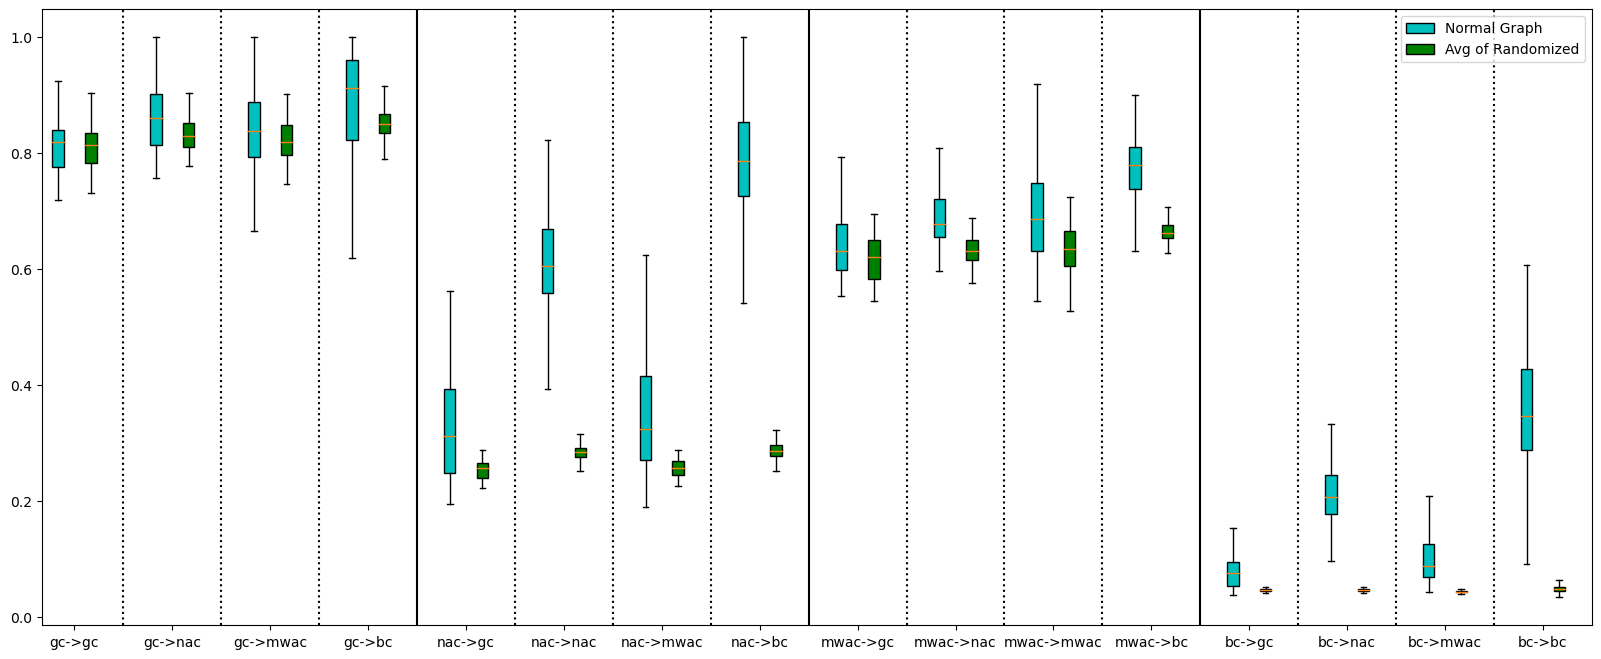

In [55]:
fig_clust_coef, axis = plt.subplots(1,1,figsize=(20,8))

Name_bx=[]
for i,lay_i in enumerate(All_limit_of_interest):
    for j,lay_j in enumerate(All_limit_of_interest):
        name_lay_i=All_limit_of_interest_name[i]
        name_lay_j=All_limit_of_interest_name[j]
        Name_bx.append(name_lay_i+'->'+name_lay_j)
Position_normal=[(i*3)+1 for i in range(16)]
Position_rdm=[(i*3)+2 for i in range(16)]
bpNormal = axis.boxplot(ALL_Clust_Coeff_mat['Cluster_local'], positions=Position_normal, widths=0.35, 
                 patch_artist=True, boxprops=dict(facecolor='c'),showfliers=False)
bpRdm = axis.boxplot(ALL_Clust_Coeff_mat['Rdm_cluster_local'], positions=Position_rdm, widths=0.35, 
                 patch_artist=True, boxprops=dict(facecolor='green'),showfliers=False)

axis.legend([bpNormal["boxes"][0], bpRdm["boxes"][0]], ['Normal Graph', 'Avg of Randomized'], loc='upper right')
for i in range(16):
    if i in [4,8,12,16]:
        axis.axvline((i*3),color='black',linestyle='-')
    else:
        axis.axvline((i*3),color='black',linestyle=':')

Position_ticks=[(i*3)+1.5 for i in range(16)]
axis.set_xticks(Position_ticks, Name_bx)
axis.set_xlim(xmin=0.5,xmax=16*3)


Text(0.5, 1.0, 'Condensation')

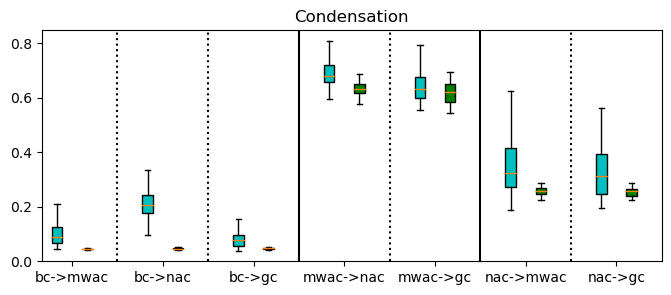

In [56]:
fig_cluster_condensation, axis = plt.subplots(1,1,figsize=(8,3))

#List_condensation=reversed([0,4,5,6,8,9,10,12,13,14,15])
#List_name_condens=reversed(['Intralyer gc','nac->gc','Intralayer nac','nac->mwac','mwac->gc','mwac->nac','Intralayer mwac',
#'bc->gc','bc->nac','bc->mwac','Intralayer bc'])
List_condensation=reversed([4,6,8,9,12,13,14])
List_name_condens=reversed(['nac->gc','nac->mwac','mwac->gc','mwac->nac','bc->gc','bc->nac','bc->mwac'])

ALL_Clust_Coeff_mat_Condesn={'Cluster_local':[],'Rdm_cluster_local':[]}
for idx_c in List_condensation:
    ALL_Clust_Coeff_mat_Condesn['Cluster_local'].append(ALL_Clust_Coeff_mat['Cluster_local'][idx_c])
    ALL_Clust_Coeff_mat_Condesn['Rdm_cluster_local'].append(ALL_Clust_Coeff_mat['Rdm_cluster_local'][idx_c])

Position_normal=[(i*3)+1 for i in range(7)]
Position_rdm=[(i*3)+2 for i in range(7)]
bpNormal = axis.boxplot(ALL_Clust_Coeff_mat_Condesn['Cluster_local'], positions=Position_normal, widths=0.35, 
                 patch_artist=True, boxprops=dict(facecolor='c'),showfliers=False)
bpRdm = axis.boxplot(ALL_Clust_Coeff_mat_Condesn['Rdm_cluster_local'], positions=Position_rdm, widths=0.35, 
                 patch_artist=True, boxprops=dict(facecolor='green'),showfliers=False)

#axis.legend([bpNormal["boxes"][0], bpRdm["boxes"][0]], ['Normal Graph', 'Avg of Randomized'], loc='upper right')
for i in range(7):
    if i in [3,5]:#[4,7,10]:
        axis.axvline((i*3),color='black',linestyle='-')
    else:
        axis.axvline((i*3),color='black',linestyle=':')

Position_ticks=[(i*3)+1.5 for i in range(7)]
axis.set_xticks(Position_ticks, List_name_condens)
axis.set_xlim(xmin=0.5,xmax=7*3)
axis.set_title('Condensation')

Text(0.5, 1.0, 'Expension')

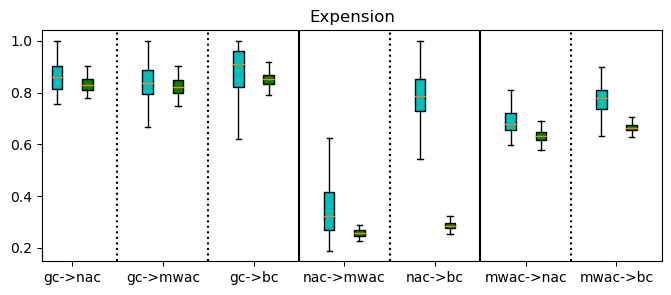

In [57]:
fig_cluster_expension, axis = plt.subplots(1,1,figsize=(8,3))

List_expension=[1,2,3,6,7,9,11]
List_name_expen=['gc->nac','gc->mwac','gc->bc','nac->mwac','nac->bc','mwac->nac','mwac->bc']

ALL_Clust_Coeff_mat_Expen={'Cluster_local':[],'Rdm_cluster_local':[]}
for idx_c in List_expension:
    ALL_Clust_Coeff_mat_Expen['Cluster_local'].append(ALL_Clust_Coeff_mat['Cluster_local'][idx_c])
    ALL_Clust_Coeff_mat_Expen['Rdm_cluster_local'].append(ALL_Clust_Coeff_mat['Rdm_cluster_local'][idx_c])

Position_normal=[(i*3)+1 for i in range(7)]
Position_rdm=[(i*3)+2 for i in range(7)]
bpNormal = axis.boxplot(ALL_Clust_Coeff_mat_Expen['Cluster_local'], positions=Position_normal, widths=0.35, 
                 patch_artist=True, boxprops=dict(facecolor='c'),showfliers=False)
bpRdm = axis.boxplot(ALL_Clust_Coeff_mat_Expen['Rdm_cluster_local'], positions=Position_rdm, widths=0.35, 
                 patch_artist=True, boxprops=dict(facecolor='green'),showfliers=False)

#axis.legend([bpNormal["boxes"][0], bpRdm["boxes"][0]], ['Normal Graph', 'Avg of Randomized'], loc='upper right')
for i in range(7):
    if i in [3,5]:#[4,7,10]:
        axis.axvline((i*3),color='black',linestyle='-')
    else:
        axis.axvline((i*3),color='black',linestyle=':')

Position_ticks=[(i*3)+1.5 for i in range(7)]
axis.set_xticks(Position_ticks, List_name_expen)
axis.set_xlim(xmin=0.5,xmax=7*3)
axis.set_title('Expension')

Text(0.5, 1.0, 'Intralayer')

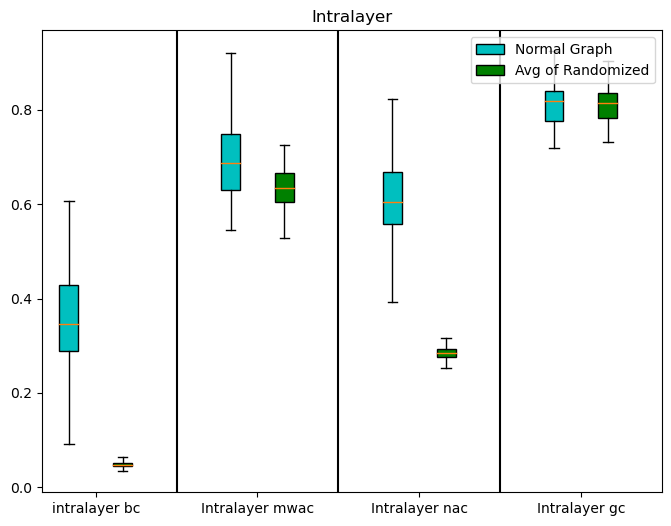

In [58]:
fig_cluster_horizontal, axis = plt.subplots(1,1,figsize=(8,6))

List_horizontal=reversed([0,5,10,15])
List_name_horiz=reversed(['Intralayer gc','Intralayer nac','Intralayer mwac','intralayer bc'])

ALL_Clust_Coeff_mat_horiz={'Cluster_local':[],'Rdm_cluster_local':[]}
for idx_c in List_horizontal:
    ALL_Clust_Coeff_mat_horiz['Cluster_local'].append(ALL_Clust_Coeff_mat['Cluster_local'][idx_c])
    ALL_Clust_Coeff_mat_horiz['Rdm_cluster_local'].append(ALL_Clust_Coeff_mat['Rdm_cluster_local'][idx_c])

Position_normal=[(i*3)+1 for i in range(4)]
Position_rdm=[(i*3)+2 for i in range(4)]
bpNormal = axis.boxplot(ALL_Clust_Coeff_mat_horiz['Cluster_local'], positions=Position_normal, widths=0.35, 
                 patch_artist=True, boxprops=dict(facecolor='c'),showfliers=False)
bpRdm = axis.boxplot(ALL_Clust_Coeff_mat_horiz['Rdm_cluster_local'], positions=Position_rdm, widths=0.35, 
                 patch_artist=True, boxprops=dict(facecolor='green'),showfliers=False)

axis.legend([bpNormal["boxes"][0], bpRdm["boxes"][0]], ['Normal Graph', 'Avg of Randomized'], loc='upper right')
for i in range(4):
    axis.axvline((i*3),color='black',linestyle='-')

Position_ticks=[(i*3)+1.5 for i in range(4)]
axis.set_xticks(Position_ticks, List_name_horiz)
axis.set_xlim(xmin=0.5,xmax=4*3)
axis.set_xlim(xmin=0.5,xmax=4*3)
axis.set_title('Intralayer')

In [59]:
#save the dict
with open('ALL_Clust_Coeff_mat.pkl', 'wb') as f:
    pickle.dump(ALL_Clust_Coeff_mat, f)
    
with open('ALL_RC_mat.pkl', 'wb') as f:
    pickle.dump(ALL_RC_mat, f)
with open('ALL_list_model_mat.pkl', 'wb') as f:
    pickle.dump(ALL_list_model_mat, f)


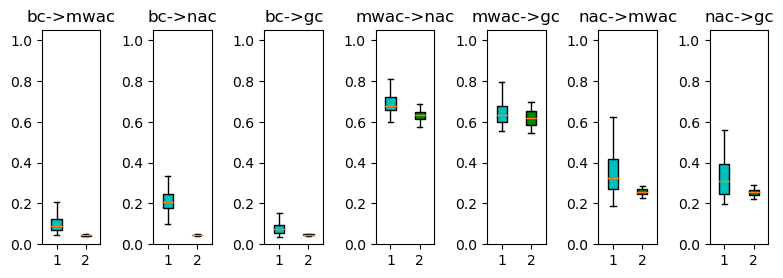

In [64]:
fig_cluster_condensation, axis = plt.subplots(1,7,figsize=(8,3))

#List_condensation=reversed([0,4,5,6,8,9,10,12,13,14,15])
#List_name_condens=reversed(['Intralyer gc','nac->gc','Intralayer nac','nac->mwac','mwac->gc','mwac->nac',...
#'Intralayer mwac','bc->gc','bc->nac','bc->mwac','Intralayer bc'])
List_condensation=reversed([4,6,8,9,12,13,14])
List_name_condens=reversed(['nac->gc','nac->mwac','mwac->gc','mwac->nac','bc->gc','bc->nac','bc->mwac'])

ALL_Clust_Coeff_mat_Condesn={'Cluster_local':[],'Rdm_cluster_local':[]}
for idx_c in List_condensation:
    ALL_Clust_Coeff_mat_Condesn['Cluster_local'].append(ALL_Clust_Coeff_mat['Cluster_local'][idx_c])
    ALL_Clust_Coeff_mat_Condesn['Rdm_cluster_local'].append(ALL_Clust_Coeff_mat['Rdm_cluster_local'][idx_c])

List_name_condens_fin=[name_i for name_i in reversed(['nac->gc','nac->mwac','mwac->gc','mwac->nac','bc->gc','bc->nac',
                                                      'bc->mwac'])]

for i,axi in enumerate(axis):
    bpNormal = axi.boxplot(ALL_Clust_Coeff_mat_Condesn['Cluster_local'][i], positions=[1], widths=0.35, 
                 patch_artist=True, boxprops=dict(facecolor='c'),showfliers=False)
    bpRdm = axi.boxplot(ALL_Clust_Coeff_mat_Condesn['Rdm_cluster_local'][i], positions=[2], widths=0.35, 
                 patch_artist=True, boxprops=dict(facecolor='green'),showfliers=False)
    axi.set_title(List_name_condens_fin[i])
    axi.set_ylim(ymin=0,ymax=1.05)
    axi.set_xlim(xmin=0.5,xmax=2+0.5)

fig_cluster_condensation.tight_layout(pad=1.5) 

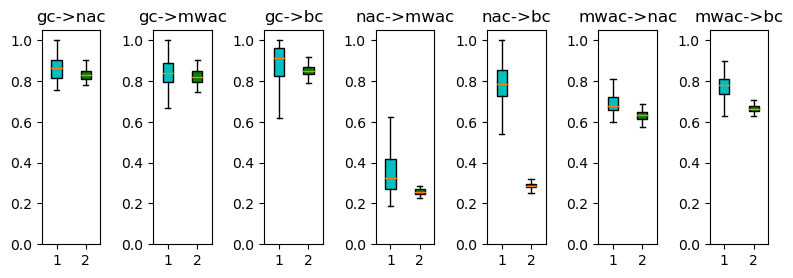

In [61]:
fig_cluster_expension, axis = plt.subplots(1,7,figsize=(8,3))

List_expension=[1,2,3,6,7,9,11]
List_name_expen=['gc->nac','gc->mwac','gc->bc','nac->mwac','nac->bc','mwac->nac','mwac->bc']

ALL_Clust_Coeff_mat_Expen={'Cluster_local':[],'Rdm_cluster_local':[]}
for idx_c in List_expension:
    ALL_Clust_Coeff_mat_Expen['Cluster_local'].append(ALL_Clust_Coeff_mat['Cluster_local'][idx_c])
    ALL_Clust_Coeff_mat_Expen['Rdm_cluster_local'].append(ALL_Clust_Coeff_mat['Rdm_cluster_local'][idx_c])

#Position_normal=[(i*3)+1 for i in range(7)]
#Position_rdm=[(i*3)+2 for i in range(7)]
for i,axi in enumerate(axis):
    bpNormal = axi.boxplot(ALL_Clust_Coeff_mat_Expen['Cluster_local'][i], positions=[1], widths=0.35, 
                 patch_artist=True, boxprops=dict(facecolor='c'),showfliers=False)
    bpRdm = axi.boxplot(ALL_Clust_Coeff_mat_Expen['Rdm_cluster_local'][i], positions=[2], widths=0.35, 
                 patch_artist=True, boxprops=dict(facecolor='green'),showfliers=False)
    axi.set_title(List_name_expen[i])
    axi.set_ylim(ymin=0,ymax=1.05)
    axi.set_xlim(xmin=0.5,xmax=2+0.5)
#axis.legend([bpNormal["boxes"][0], bpRdm["boxes"][0]], ['Normal Graph', 'Avg of Randomized'], loc='upper right')
#for i in range(7):
#    if i in [3,5]:#[4,7,10]:
#        axis.axvline((i*3),color='black',linestyle='-')
#    else:
#        axis.axvline((i*3),color='black',linestyle=':')
#
#Position_ticks=[(i*3)+1.5 for i in range(7)]
#axis.set_xticks(Position_ticks, List_name_expen)
#axis.set_xlim(xmin=0.5,xmax=7*3)
#axis.set_title('Expension')
fig_cluster_expension.tight_layout(pad=1.5) 


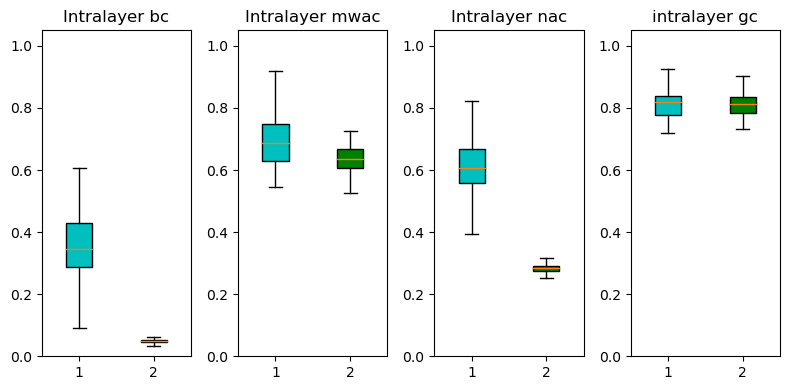

In [62]:
fig_cluster_horizontal, axis = plt.subplots(1,4,figsize=(8,4))

List_horizontal=reversed([0,5,10,15])
List_name_horiz=reversed(['Intralayer gc','Intralayer nac','Intralayer mwac','intralayer bc'])

ALL_Clust_Coeff_mat_horiz={'Cluster_local':[],'Rdm_cluster_local':[]}
for idx_c in List_horizontal:
    ALL_Clust_Coeff_mat_horiz['Cluster_local'].append(ALL_Clust_Coeff_mat['Cluster_local'][idx_c])
    ALL_Clust_Coeff_mat_horiz['Rdm_cluster_local'].append(ALL_Clust_Coeff_mat['Rdm_cluster_local'][idx_c])

#Position_normal=[(i*2)+1 for i in range(4)]
#Position_rdm=[(i*2)+2 for i in range(4)]
for i,axi in enumerate(axis):
    bpNormal = axi.boxplot(ALL_Clust_Coeff_mat_horiz['Cluster_local'][i],positions=[1] ,widths=0.35, 
                 patch_artist=True, boxprops=dict(facecolor='c'),showfliers=False)
    bpRdm = axi.boxplot(ALL_Clust_Coeff_mat_horiz['Rdm_cluster_local'][i], positions=[2] ,widths=0.35, 
                 patch_artist=True, boxprops=dict(facecolor='green'),showfliers=False)
    axi.set_title(['Intralayer bc','Intralayer mwac','Intralayer nac','intralayer gc'][i])
    axi.set_ylim(ymin=0,ymax=1.05)
    axi.set_xlim(xmin=0.5,xmax=2+0.5)
#axis.legend([bpNormal["boxes"][0], bpRdm["boxes"][0]], ['Normal Graph', 'Avg of Randomized'], loc='upper right')
#for i in range(4):
#    axis.axvline((i*2)+0.5,color='black',linestyle='-')

#Position_ticks=[(i*2)+1.5 for i in range(4)]
#axis.set_xticks(Position_ticks, List_name_horiz)
#axis.set_xlim(xmin=0.5,xmax=4*2+0.5)
#axis.set_xlim(xmin=0.5,xmax=4*2+0.5)
#axis.set_title('Intralayer')
fig_cluster_horizontal.tight_layout() 
